In [1]:
import os
import glob
import gzip
import pickle
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from metient.util import plotting_util as putil
from metient.util import vertex_labeling_util as vutil

from metient.util.globals import *

four_dataset_colors = {"Melanoma":"#b84988","HGSOC":"#06879e","HR-NB":"#5a9e09", "NSCLC":"#d4892a"}

REPO_DIR = '/lila/data/morrisq/divyak/projects/metient/metient/'
OUTPUT_DIR = os.path.join(REPO_DIR, 'jupyter_notebooks', 'output_plots')
DATASET_NAMES = ["Breast Cancer", "HGSOC", "Melanoma", "HR-NB", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/hoadley_breast_cancer_2016/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs_solve_polys_no_cna_pyclone_vi_orchard", "calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/tracerx_trees_06062024/calibrate",)]

U_INFERRED_DATASETS = ["Breast Cancer","Melanoma", "HR-NB"]

desired_order = ["single-source", 'multi-source', "reseeding", "primary single-source"]

/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Helper functions

In [2]:
import pyreadr
import torch 
from metient.metient import *

def split_pattern_clonality(full_pattern):
    clonality = full_pattern.split(" ")[0]
    pattern = " ".join(full_pattern.split(" ")[1:]).replace(" seeding", "")
    return pattern, clonality

def get_tracerx_subtype(pid):
    # Get NSCLC subtype (LUAD and LUSC)
    tracerx_patient_info = pyreadr.read_r(os.path.join('/data/morrisq/divyak/data/tracerx_nsclc_2023/20221109_TRACERx421_all_patient_df.rds'))[None]
    tracerx_patient_info['histology_multi_full_genomically.confirmed'].value_counts()

    subtype = tracerx_patient_info[tracerx_patient_info['cruk_id']==pid]['histology_multi_full_genomically.confirmed'].item()
    subtype = "LUAD" if "LUAD" in subtype else subtype
    if subtype == "Other":
        print("Not LUAD or LUSC subtype", pid)
        return "N/A"
    return subtype

def is_ln(met_site):
    return met_site.startswith("LN") or "lymph" in met_site or "Lymph" in met_site

def get_internal_clone_tree(T,U):
    num_internal_clones = U.shape[1] - 1 # don't include normal cells
    T = T[:num_internal_clones,:num_internal_clones]
    return T

def get_B(T, U):
    T = get_internal_clone_tree(T,U)
    B = vutil.mutation_matrix(T)
    # add a row of zeros to account for the non-cancerous root node
    B = torch.vstack([torch.zeros(B.shape[1]), B])
    # add a column of ones to indicate that every clone is a descendent of the non-cancerous root node
    B = torch.hstack([torch.ones(B.shape[0]).reshape(-1,1), B])
    return B

pts = set()
def get_root_clone_presence_in_met(dataset, pid, idx_to_label, primary, U, A, sites):
    root_idx = vutil.get_root_index(A)
    root_node_muts = ";".join(idx_to_label[root_idx][0])
    root_clone_site = "None"
    root_clone_sites = []
    for i in idx_to_label:
        is_observed_clone = idx_to_label[i][1]
        muts = idx_to_label[i][0]
        # -1 because the last label includes the site label
        if i != root_idx and is_observed_clone and ";".join(muts[:-1])==root_node_muts and muts[-1] != primary and 'primary' not in muts[-1]:
            root_clone_sites.append(muts[-1])
    is_in_ln, is_in_distant = False, False
    for site in root_clone_sites:
        if is_ln(site):
            is_in_ln = True
        else:
            is_in_distant = True
    if is_in_ln and is_in_distant:
        root_clone_site = "Both"
    elif is_in_ln:
        root_clone_site = "Lymph node"
    elif is_in_distant:
        root_clone_site = "Distant"
   
    return root_clone_site

def get_seeding_info(index_order, pkl):
    V = torch.tensor(pkl[OUT_LABElING_KEY][index_order[0][0]])
    A = torch.tensor(pkl[OUT_ADJ_KEY][index_order[0][0]])
    pattern = putil.seeding_pattern(V,A)
    G = putil.migration_graph(V,A)
    num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
    num_ss = (G!=0).any(dim=1).sum().item()
    seeding_clusters = putil.seeding_clusters(V, A)
    return pattern, num_migs_polyclonal, num_ss, seeding_clusters

def get_pattern_clonality_phyleticity(V,A):
    pattern = putil.seeding_pattern(V,A)
    st_clonality = putil.site_clonality(V,A)
    gen_clonality = putil.genetic_clonality(V,A)
    phyl = putil.phyleticity(V,A)
    tracerx_phyl = putil.tracerx_phyleticity(V,A)
    return pattern, st_clonality, gen_clonality, phyl, tracerx_phyl
    

CUDA GPU: False


### Load all calibrate inferred trees

What are different metrics (e.g. seeding pattern, clonality, phyleticity) for the top tree, as determined by calibrate? or by a seeding site penalizing model? or migration number penalizing model?

In [3]:

data = []

for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):
    # Use glob to get the list of matching files
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            
            pid = fn.split("/")[-1].split("_")[0]
            pkl = pickle.load(f)
            
            # Best calibrated tree
            V = torch.tensor(pkl[OUT_LABElING_KEY][0])
            A = torch.tensor(pkl[OUT_ADJ_KEY][0])
            U = pkl[OUT_SUB_PRES_KEY]
            losses = [l.item() for l in pkl[OUT_LOSSES_KEY]]
            sites = pkl[OUT_SITES_KEY]
            idx_to_label = pkl[OUT_IDX_LABEL_KEY][0]
            
            cal_pattern,cal_st_clonality,cal_gen_clonality,cal_phyletic,cal_tracerx_phyletic =  get_pattern_clonality_phyleticity(V, A)
            G = putil.migration_graph(V,A)
            cal_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            cal_num_ss = (G!=0).any(dim=1).sum().item()
            cal_prop_met_sites = (cal_num_ss-1)/(len(sites)-1) * 100
            cal_seeding_clusters = putil.seeding_clusters(V, A)
            primary = pkl[OUT_PRIMARY_KEY]
            
            # How many patients have root clone observed in a met 
            root_clone_in_met = get_root_clone_presence_in_met(dataset, pid, idx_to_label, primary, U, A, sites)
            
            # Gather the solution with lowest migration number, comigration number, or seeding site
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            pars_metrics = []
            for l in loss_dicts:
                pars_metrics.append((int(l[MIG_KEY]), int(l[COMIG_KEY]), int(l[SEEDING_KEY])))
            
            mig_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][0], x[1][1], x[1][2]))
            mig_num_pattern, mig_num_migs_polyclonal, mig_num_ss, _ = get_seeding_info(mig_sorted_indices, pkl)
            
            comig_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][1], x[1][0], x[1][2]))
            comig_num_pattern, comig_num_migs_polyclonal, comig_num_ss, _ = get_seeding_info(comig_sorted_indices, pkl)

            ss_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][2], x[1][0], x[1][1]))
            ss_num_pattern, ss_num_migs_polyclonal, ss_num_ss, ss_seeding_clusters = get_seeding_info(ss_sorted_indices, pkl)
            
            num_trees_on_pareto = len(pars_metrics)
            mult_trees_w_same_pars_metrics = True if len(set(pars_metrics)) < len(pars_metrics) else False
            mult_trees_w_diff_pars_metrics = True if len(set(pars_metrics)) != 1 else False
            
            subtype = "N/A"
            if dataset == 'NSCLC':
                subtype = get_tracerx_subtype(pid)

            data.append([dataset, pid, fn, losses[0], subtype, len(sites), num_trees_on_pareto,mult_trees_w_same_pars_metrics,mult_trees_w_diff_pars_metrics, root_clone_in_met,
                         cal_pattern, cal_st_clonality, cal_gen_clonality, cal_phyletic, cal_tracerx_phyletic, cal_num_migs_polyclonal,cal_num_ss,cal_seeding_clusters,cal_prop_met_sites,
                         mig_num_pattern, mig_num_migs_polyclonal,mig_num_ss,
                         comig_num_pattern, comig_num_migs_polyclonal,comig_num_ss,
                         ss_num_pattern,ss_num_migs_polyclonal,ss_num_ss, ss_seeding_clusters, pars_metrics])
    

trees_df = pd.DataFrame(data, columns=['Dataset', "Patient id", "Filename", "Lowest cal loss", "Subtype", 'Num sites', 'Num trees on Pareto', 'Multiple trees w/ same pars metrics','Multiple trees w/ diff pars metrics', "Root clone observed site",
                                       'Top cal seeding pattern', 'Top cal site clonality', 'Top cal genetic clonality', 'Top cal phyleticity', 'Top cal tracerx phyleticity', 'Top cal % migs poly','Top cal num ss', 'Top cal seeding clusters', 'Top cal % metastatic sites',
                                       'Lowest mig seeding pattern', 'Lowest mig % migs poly','Lowest mig num ss',
                                       'Lowest comig seeding pattern', 'Lowest comig % migs poly','Lowest comig num ss',
                                       'Lowest ss seeding pattern', 'Lowest ss % migs poly','Lowest ss num ss', 'Lowest ss seeding clusters', 'Pars metrics'])

# When there are patients with multiple possible primaries, only keep the solution with the lowest loss 
idx = trees_df.groupby(['Dataset', 'Patient id'])['Lowest cal loss'].idxmin()
trees_df = trees_df.loc[idx].reset_index(drop=True)


Breast Cancer 0
HGSOC 13
Melanoma 7
HR-NB 30
NSCLC 128
Not LUAD or LUSC subtype CRUK0702
Not LUAD or LUSC subtype CRUK0514
Not LUAD or LUSC subtype CRUK0325
Not LUAD or LUSC subtype CRUK0718
Not LUAD or LUSC subtype CRUK0422
Not LUAD or LUSC subtype CRUK0596
Not LUAD or LUSC subtype CRUK0476
Not LUAD or LUSC subtype CRUK0719
Not LUAD or LUSC subtype CRUK0100
Not LUAD or LUSC subtype CRUK0557
Not LUAD or LUSC subtype CRUK0099
Not LUAD or LUSC subtype CRUK0587
Not LUAD or LUSC subtype CRUK0524
Not LUAD or LUSC subtype CRUK0484
Not LUAD or LUSC subtype CRUK0769
Not LUAD or LUSC subtype CRUK0097
Not LUAD or LUSC subtype CRUK0698
Not LUAD or LUSC subtype CRUK0640
Not LUAD or LUSC subtype CRUK0013
Not LUAD or LUSC subtype CRUK0598
Not LUAD or LUSC subtype CRUK0245


In [4]:
from scipy.interpolate import griddata
import numpy as np

CALIBRATE_CHOICE_COLOR = "#658b38"
def get_pareto_metrics(jitter=0.0,restrict=False):

    data = []
    for i,row in trees_df.iterrows():
        metrics = row['Pars metrics']
        if not restrict or (restrict and len(set(metrics)) > 1):
            for i, tup in enumerate(metrics):
                color = CALIBRATE_CHOICE_COLOR if i == 0 else "#db5856"
                calibrate_choice = True if i == 0 else False
                m = tup[0]+ np.random.uniform(-jitter, jitter)
                c = tup[1]+ np.random.uniform(-jitter, jitter)
                s = tup[2]+ np.random.uniform(-jitter, jitter)
                data.append([m,c,s,color,row['Dataset'],calibrate_choice] )
                

    df = pd.DataFrame(data, columns=['m', 'c', 's', 'color', 'dataset', 'calibrate_choice'])
    return df


109


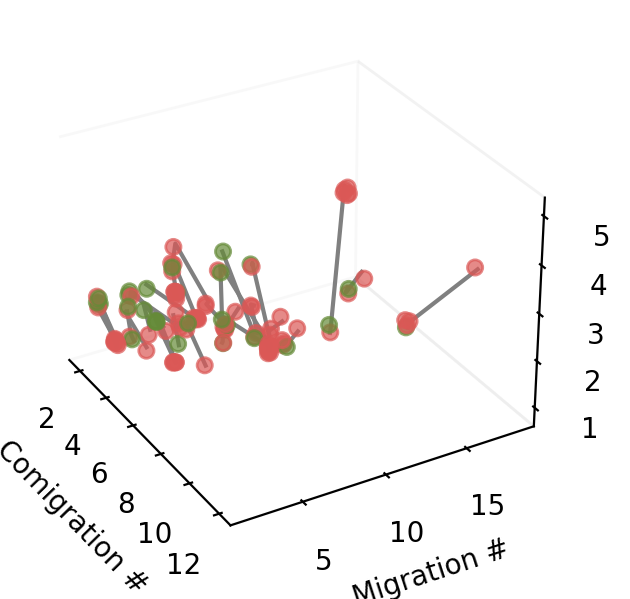

In [5]:
# Creating a 3D scatter plot
fig = plt.figure(figsize=(3,3),dpi=200)
ax = fig.add_subplot(111, projection='3d')
df = get_pareto_metrics(0.1, True)
x,y,z = np.array(df['c']), np.array(df['m']), np.array(df['s'])
colors = df['color']
print(len(colors))

sc = ax.scatter(x, y, z, c=df['color'], marker='o', alpha=0.7,s=30)
for metrics in trees_df['Pars metrics']:
    jitter=0.1
    if len(set(metrics)) > 1:
        patient_ms,patient_cs,patient_ss,colors = [],[],[],[]
        for i, tup in enumerate(metrics):
            patient_ms.append(tup[0]+ np.random.uniform(-jitter, jitter))
            patient_cs.append(tup[1]+ np.random.uniform(-jitter, jitter))
            patient_ss.append(tup[2]+ np.random.uniform(-jitter, jitter))
        ax.plot(patient_cs,patient_ms,patient_ss,c='grey')
        
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Optionally, remove the grid lines for a cleaner look
ax.grid(False)


# Setting labels
ax.set_xlabel('Comigration #')
ax.set_ylabel('Migration #')
ax.set_zlabel('Seeding sites')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)  # Adjust these values as needed
fig.tight_layout()  # Auto adjust layout to fit elements

# Adjust viewing angle if necessary
ax.view_init(elev=30, azim=-30)  # Change elevation and azimuth
# # Title for the plot
# ax.set_title('3D Pareto Front')

# # Show plot
plt.show()

In [40]:
pids = []
for i, row in trees_df.iterrows():
    if len(set(row['Pars metrics'])) > 1:
        #print(row['Patient id'], len(set(row['Pars metrics'])))
        pids.append(row['Patient id'])
pids
# pids = ['H118706', 'CRUK0620', 'CRUK0559', 'CRUK0290']

['H103207',
 'H118706',
 'H132374',
 'H132384',
 'H132396',
 'H134819',
 'H134821',
 'B',
 'E',
 'CRUK0013',
 'CRUK0029',
 'CRUK0090',
 'CRUK0242',
 'CRUK0245',
 'CRUK0256',
 'CRUK0290',
 'CRUK0311',
 'CRUK0465',
 'CRUK0468',
 'CRUK0484',
 'CRUK0487',
 'CRUK0559',
 'CRUK0590',
 'CRUK0620',
 'CRUK0698',
 'CRUK0736',
 'CRUK0748',
 'CRUK0810']

[(11, 5, 1), (10, 7, 2)]
[(9, 5, 3), (11, 4, 1), (10, 6, 2)]
[(7, 5, 3), (10, 5, 1)]
[(6, 3, 2), (5, 4, 3), (8, 2, 1)]
[['Migration #', 'Comigration #', 'Seeding sites'], ('H118706', [[10, 14, 6], [11, 10, 3]]), ('CRUK0620', [[10, 12, 6], [11, 8, 3], [9, 10, 9]]), ('CRUK0559', [[10, 10, 3], [7, 10, 9]]), ('CRUK0290', [[8, 4, 3], [5, 8, 9], [6, 6, 6]])]


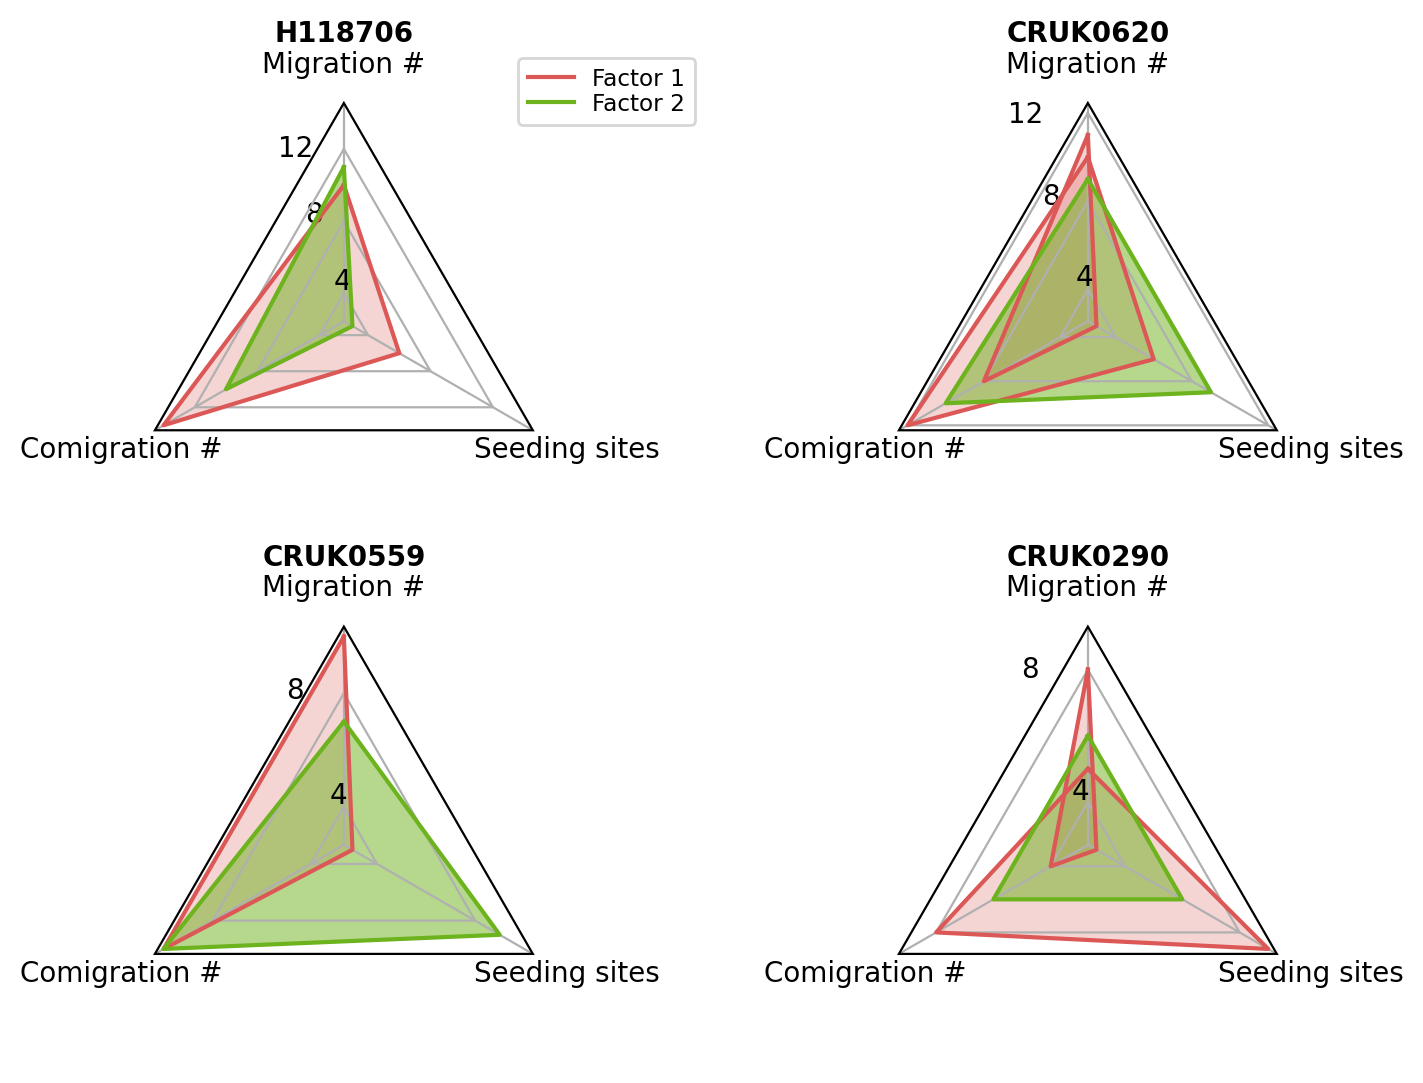

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def get_patient_pars_metrics(pids):
    
    data = [['Migration #', 'Comigration #', 'Seeding sites']]
    for pid in pids:
        patient_df = trees_df[trees_df['Patient id']==pid]
        unique_metrics = []
        for m in list(patient_df['Pars metrics'])[0]:
            if m not in unique_metrics:
                unique_metrics.append(m)
        print(unique_metrics)
        reversed_metrics = unique_metrics[::-1]
        processed = [[x[0],x[1]*2,x[2]*3] for x in reversed_metrics]
        data.append((pid,processed))

    
    return data


N = 3
theta = radar_factory(N, frame='polygon')

data = get_patient_pars_metrics(pids)
print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=2,
                        subplot_kw=dict(projection='radar'),dpi=200)
fig.subplots_adjust(wspace=0.5, hspace=0.20, top=0.85, bottom=0.05)


# Plot the four cases from the example data on separate Axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([4,8,12,16])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    colors = ["#db5856" for _ in range(len(case_data)-1)]+["#6cb31d"]
    alphas = [0.25 for _ in range(len(case_data)-1)]+[0.5]
    for d, color, alpha in zip(case_data, colors, alphas):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=alpha, label='_nolegend_')
    ax.set_varlabels(spoke_labels, )

# add legend relative to top-left plot
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                          labelspacing=0.1, fontsize='small')

plt.savefig(os.path.join(OUTPUT_DIR, f"pareto_treadeoff_examples.png"), dpi=300,  bbox_inches='tight', pad_inches=0.2)

plt.show()

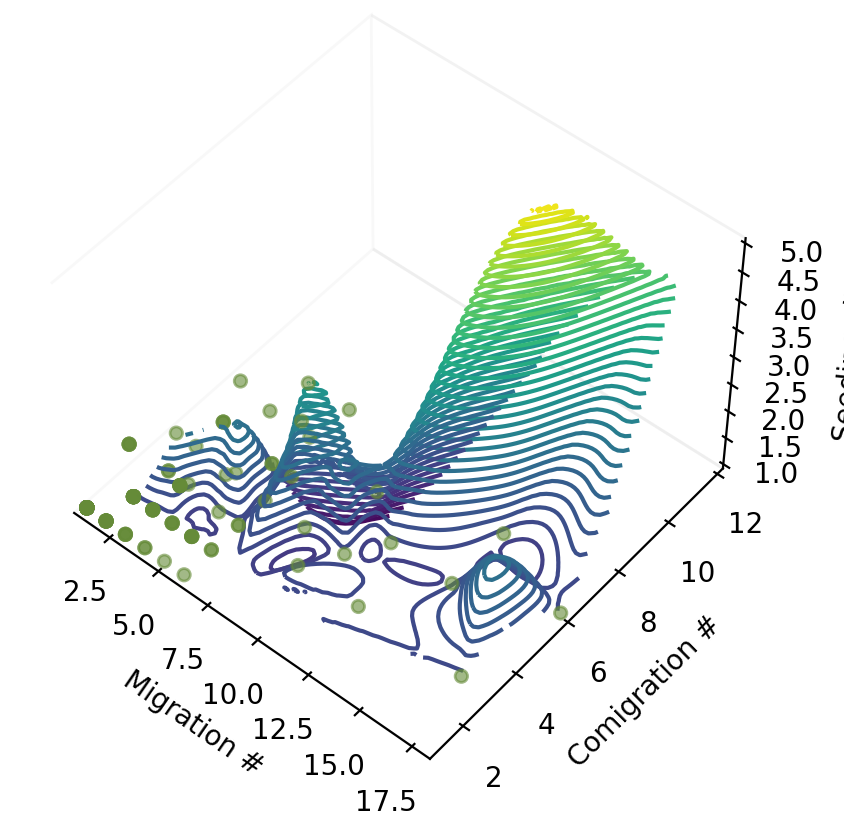

In [8]:

fig = plt.figure(figsize=(4,4),dpi=200)
df = get_pareto_metrics(0, False)
x,y,z = np.array(df['m']), np.array(df['c']), np.array(df['s'])
colors = df['color']

calibrate_xs = [x[i] for i in range(len(colors)) if colors[i] == CALIBRATE_CHOICE_COLOR]
calibrate_ys = [y[i] for i in range(len(colors)) if colors[i] == CALIBRATE_CHOICE_COLOR]
calibrate_zs = [z[i] for i in range(len(colors)) if colors[i] == CALIBRATE_CHOICE_COLOR]

ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(calibrate_xs, calibrate_ys, calibrate_zs, c=CALIBRATE_CHOICE_COLOR, marker='o', alpha=0.6)

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
Xi, Yi = np.meshgrid(xi, yi)


# Interpolate unstructured D-dimensional data
Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

contour = ax.contour3D(Xi, Yi, Zi, 50, )

#colors = np.linalg.norm(pareto_points, axis=1)  # Example: color by the norm of the points
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Optionally, remove the grid lines for a cleaner look
ax.grid(False)

# Set explicit axes limits if necessary
ax.set_xlim([min(xi), max(xi)])
ax.set_ylim([min(yi), max(yi)])
ax.set_zlim([np.min(z), np.max(z)])

# Setting labels
ax.set_xlabel('Migration #')
ax.set_ylabel('Comigration #')
ax.set_zlabel('Seeding sites')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)  # Adjust these values as needed
fig.tight_layout()  # Auto adjust layout to fit elements

# Adjust viewing angle if necessary
ax.view_init(elev=50, azim=-50)  # Change elevation and azimuth
# # Title for the plot
# ax.set_title('3D Pareto Front')

# # Show plot
plt.show()

In [9]:
# how many total sites do we have across all patients
print("Unique anatomical sites", sum(trees_df.groupby('Patient id')['Num sites'].mean()))

# how many unique patients
print("Unique patients", len(trees_df['Patient id'].unique()))


Unique anatomical sites 479
Unique patients 167


In [10]:
tracerx_clonality_divergences = pd.read_csv("./output_plots/tracerx_divergence_timing.tsv", sep="\t")
print(tracerx_clonality_divergences)
pts_w_root_clone_in_met = trees_df[(trees_df['Dataset']=='NSCLC')&(trees_df['Root clone observed site']!='None')]['Patient id'].unique()
print(pts_w_root_clone_in_met)
pts_w_early_clonality_div = tracerx_clonality_divergences[tracerx_clonality_divergences['Divergence time']=='early']['Patient']
both = set(pts_w_root_clone_in_met).intersection(set(pts_w_early_clonality_div))
print(len(both), both)

     Unnamed: 0   Patient Divergence time
0             0  CRUK0472           early
1             1  CRUK0052           early
2             2  CRUK0311           early
3             3  CRUK0444            late
4             4  CRUK0036            late
..          ...       ...             ...
121         121  CRUK0484            late
122         122  CRUK0495            late
123         123  CRUK0497            late
124         124  CRUK0286            late
125         125  CRUK0090           early

[126 rows x 3 columns]
['CRUK0041' 'CRUK0099' 'CRUK0178' 'CRUK0206' 'CRUK0245' 'CRUK0290'
 'CRUK0301' 'CRUK0465' 'CRUK0495' 'CRUK0528' 'CRUK0636']
2 {'CRUK0465', 'CRUK0290'}


### How many patients have the root clone detected in a met?

Unique patients with a root clone observed in met: 22
0 3 1
0 4 0
0 2 1
6 4 1
    Dataset  Root clone in LN  Root clone in distant  Root clone in both
0  Melanoma             0.000                 42.857              14.286
1     HGSOC             0.000                 57.143               0.000
2     HR-NB             0.000                  7.407               3.704
3     NSCLC             4.762                  3.175               0.794


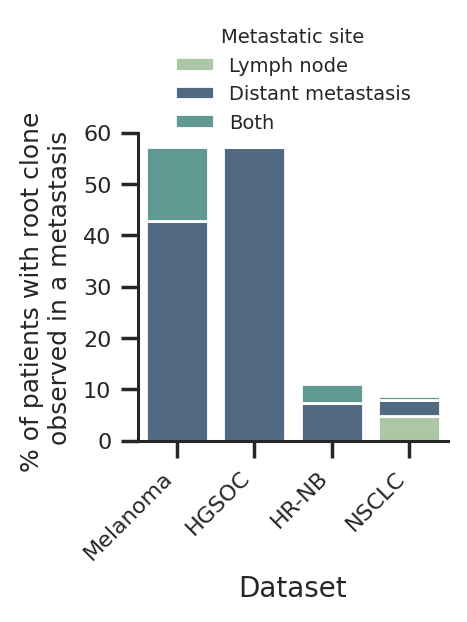

In [11]:

def adjust_lightness(hex_color, amount=0.5):
    import colorsys
    import matplotlib.colors as mc
    h = hex_color.strip("#")
    c = tuple(float(int(h[i:i+2], 16)/256) for i in (0, 2, 4))
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

print("Unique patients with a root clone observed in met:", len(trees_df[trees_df['Root clone observed site']!='None']['Patient id'].unique()))

root_clone_in_ln_met_df = trees_df[(trees_df['Root clone observed site']=='Lymph node')]
root_clone_in_other_met_df = trees_df[(trees_df['Root clone observed site']=='Distant')]
root_clone_in_both_df = trees_df[(trees_df['Root clone observed site']=='Both')]

data = []
for dataset in four_dataset_colors.keys():
    num_tot_pts = len(trees_df[trees_df['Dataset']==dataset]['Patient id'].unique())
    num_root_clone_in_ln_met_pts = len(root_clone_in_ln_met_df[(root_clone_in_ln_met_df['Dataset']==dataset)]['Patient id'].unique())
    num_root_clone_in_other_met_pts = len(root_clone_in_other_met_df[(root_clone_in_other_met_df['Dataset']==dataset)]['Patient id'].unique())
    num_root_clone_both_met_pts = len(root_clone_in_both_df[(root_clone_in_both_df['Dataset']==dataset)]['Patient id'].unique())

    print(num_root_clone_in_ln_met_pts,num_root_clone_in_other_met_pts, num_root_clone_both_met_pts )
    data.append([dataset, 100*(num_root_clone_in_ln_met_pts/num_tot_pts), 100*(num_root_clone_in_other_met_pts/num_tot_pts), 100*(num_root_clone_both_met_pts/num_tot_pts)])

root_clone_df = pd.DataFrame(data, columns=['Dataset', 'Root clone in LN', 'Root clone in distant', 'Root clone in both'])
print(root_clone_df)
sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.1})
plt.figure(figsize=(2, 2), dpi=200)
ln_colors = ['#A8CD9F']
distant_colors = ['#496989']
both_colors = ['#58A399']
sns.barplot(x='Dataset', y='Root clone in LN', data=root_clone_df, palette=ln_colors, order=four_dataset_colors.keys(), label="Lymph node")
sns.barplot(x='Dataset', y='Root clone in distant', data=root_clone_df, palette=distant_colors, order=four_dataset_colors.keys(), label="Distant metastasis", bottom=root_clone_df['Root clone in LN'])
snsfig=sns.barplot(x='Dataset', y='Root clone in both', data=root_clone_df, palette=both_colors, order=four_dataset_colors.keys(), label="Both", bottom=root_clone_df['Root clone in distant']+root_clone_df['Root clone in LN'])
# snsfig = sns.barplot(x=DATASET_NAMES[1:], y=ys, palette=four_dataset_colors.values(), order=four_dataset_colors.keys())
plt.ylabel("% of patients with root clone \nobserved in a metastasis", fontsize=9)
plt.xlabel("Dataset")
handles, labels = snsfig.get_legend_handles_labels()  # Get existing handles and labels

legend = snsfig.legend(handles=handles, labels=labels, loc='upper center',  bbox_to_anchor=(0.5, 1.4), ncol=1, 
           frameon=False, fontsize=7)
legend.set_title("Metastatic site", prop={'size': 7})  # Change '10' to your desired fontsize

plt.ylim(0,60)
snsfig.set_xticklabels(snsfig.get_xticklabels(), rotation=45, horizontalalignment='right')
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR, f"percent_pts_root_clone_in_met.png"), dpi=300,  bbox_inches='tight', pad_inches=0.2)


### How many trees are on the Pareto front?

Average number of pareto front trees with 1 met: 1.2417582417582418
Average number of pareto front trees with > 1 met: 2.8157894736842106
Average number of pareto front trees: 1.9580838323353293
Max number of pareto front trees: 16
Percent of patients with multiple trees: 0.437125748502994
Percent of patients with multiple trees w/ same parsimony metric: 0.38922155688622756
Percent of patients with multiple trees w/ different parsimony metric: 0.16766467065868262


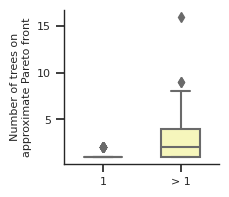

In [12]:
one_met_df = trees_df[trees_df['Num sites'] == 2]
multi_met_df = trees_df[trees_df['Num sites'] > 2]
print("Average number of pareto front trees with 1 met:", one_met_df['Num trees on Pareto'].mean())
print("Average number of pareto front trees with > 1 met:", multi_met_df['Num trees on Pareto'].mean())
print("Average number of pareto front trees:", trees_df['Num trees on Pareto'].mean())
print("Max number of pareto front trees:", trees_df['Num trees on Pareto'].max())

# Number of patients with multiple trees
percent_patients = len(trees_df[(trees_df['Multiple trees w/ same pars metrics']==1)|(trees_df['Multiple trees w/ diff pars metrics']==1)])/len(trees_df)
print("Percent of patients with multiple trees:", percent_patients)

# How many patients have a pareto front with multiple trees with the same parsimony metric
percent_patients = len(trees_df[trees_df['Multiple trees w/ same pars metrics']==1])/len(trees_df)
print("Percent of patients with multiple trees w/ same parsimony metric:", percent_patients)

# How many patients have a pareto front with multiple trees with different parsimony metrics
percent_patients = len(trees_df[trees_df['Multiple trees w/ diff pars metrics']==1])/len(trees_df)
print("Percent of patients with multiple trees w/ different parsimony metric:", percent_patients)

sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
plt.figure(figsize=(2, 2), dpi=100)
snsfig = sns.boxplot(data=[one_met_df['Num trees on Pareto'], multi_met_df['Num trees on Pareto']], 
            width=0.5, palette="Set3")
plt.ylabel("Number of trees on\napproximate Pareto front", fontsize=8)
plt.xticks([0, 1], ['1', '> 1'])
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)

In [13]:
num_same_clones = 0
num_diff_clones = 0
num_pts_diff_clones = 0
for i,row in trees_df.iterrows():
    top_cal_clusters = set(row['Top cal seeding clusters'])
    lowest_ss_clusters = set(row['Lowest ss seeding clusters'])
    num_same_clones += len(top_cal_clusters.intersection(lowest_ss_clusters))
    num_diff_clones += len(top_cal_clusters.symmetric_difference(lowest_ss_clusters))
    if len(top_cal_clusters.symmetric_difference(lowest_ss_clusters)) != 0:
        num_pts_diff_clones += 1

print("same clones", num_same_clones, "diff clones", num_diff_clones, "num_pts_diff_clones", num_pts_diff_clones)

same clones 351 diff clones 22 num_pts_diff_clones 13


### Visualize top calibrated seeding patterns together in a stacked bar plot

Index(['multi-source', 'primary single-source', 'reseeding', 'single-source'], dtype='object', name='Top cal seeding pattern') Top cal seeding pattern  multi-source  primary single-source  reseeding  \
Dataset                                                                   
   NSCLC                        1.587                 88.095      0.794   
  HR-NB                         3.704                 85.185      0.000   
 HGSOC                          0.000                100.000      0.000   
Melanoma                        0.000                100.000      0.000   

Top cal seeding pattern  single-source  
Dataset                                 
   NSCLC                         9.524  
  HR-NB                         11.111  
 HGSOC                           0.000  
Melanoma                         0.000  


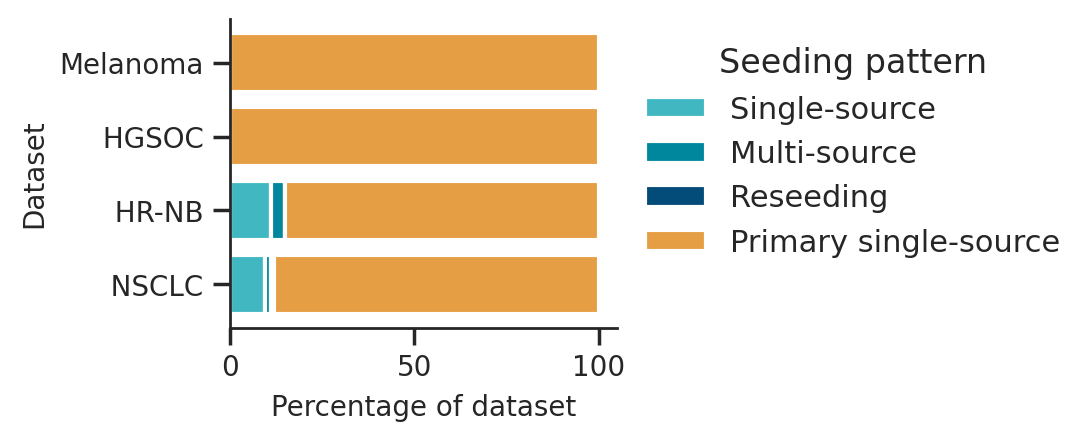

Index(['multi-source', 'primary single-source', 'reseeding', 'single-source'], dtype='object', name='Lowest mig seeding pattern') Lowest mig seeding pattern  multi-source  primary single-source  reseeding  \
Dataset                                                                      
   NSCLC                           2.381                 84.921      3.175   
  HR-NB                            7.407                 74.074      7.407   
 HGSOC                             0.000                100.000      0.000   
Melanoma                           0.000                 71.429     28.571   

Lowest mig seeding pattern  single-source  
Dataset                                    
   NSCLC                            9.524  
  HR-NB                            11.111  
 HGSOC                              0.000  
Melanoma                            0.000  


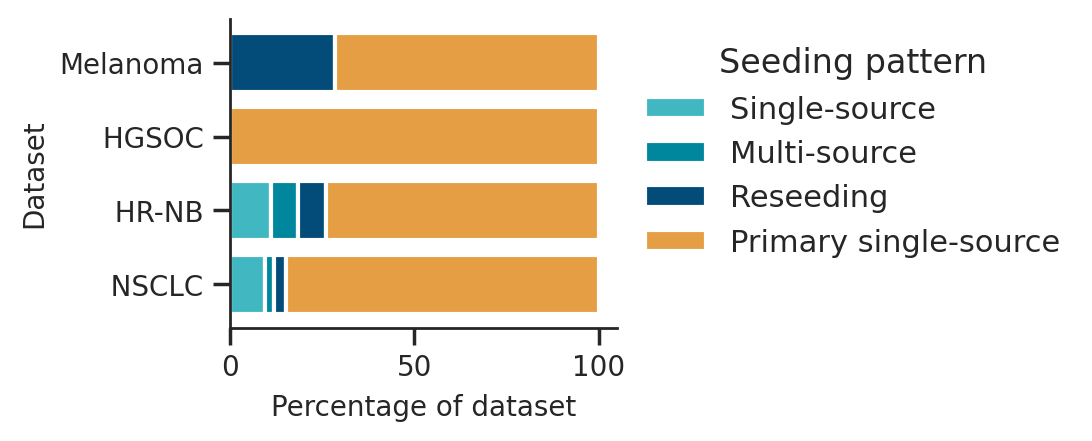

Index(['primary single-source', 'single-source', 'multi-source', 'reseeding'], dtype='object', name='Lowest comig seeding pattern') Lowest comig seeding pattern  primary single-source  single-source  \
Dataset                                                              
   NSCLC                                     89.683         10.317   
  HR-NB                                      88.889         11.111   
 HGSOC                                      100.000          0.000   
Melanoma                                    100.000          0.000   

Lowest comig seeding pattern  multi-source  reseeding  
Dataset                                                
   NSCLC                             0.000      0.000  
  HR-NB                              0.000      0.000  
 HGSOC                               0.000      0.000  
Melanoma                             0.000      0.000  


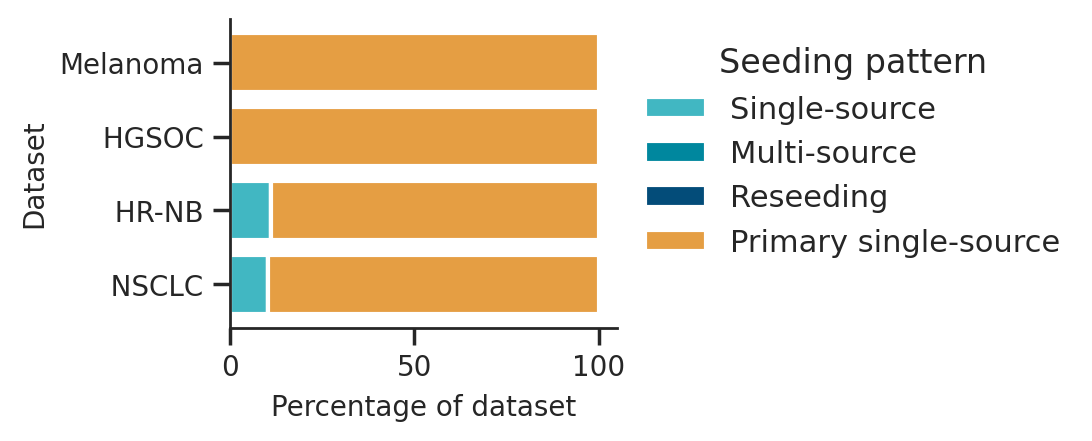

Index(['primary single-source', 'single-source', 'multi-source', 'reseeding'], dtype='object', name='Lowest ss seeding pattern') Lowest ss seeding pattern  primary single-source  single-source  multi-source  \
Dataset                                                                         
   NSCLC                                 100.000          0.000         0.000   
  HR-NB                                  100.000          0.000         0.000   
 HGSOC                                   100.000          0.000         0.000   
Melanoma                                 100.000          0.000         0.000   

Lowest ss seeding pattern  reseeding  
Dataset                               
   NSCLC                       0.000  
  HR-NB                        0.000  
 HGSOC                         0.000  
Melanoma                       0.000  


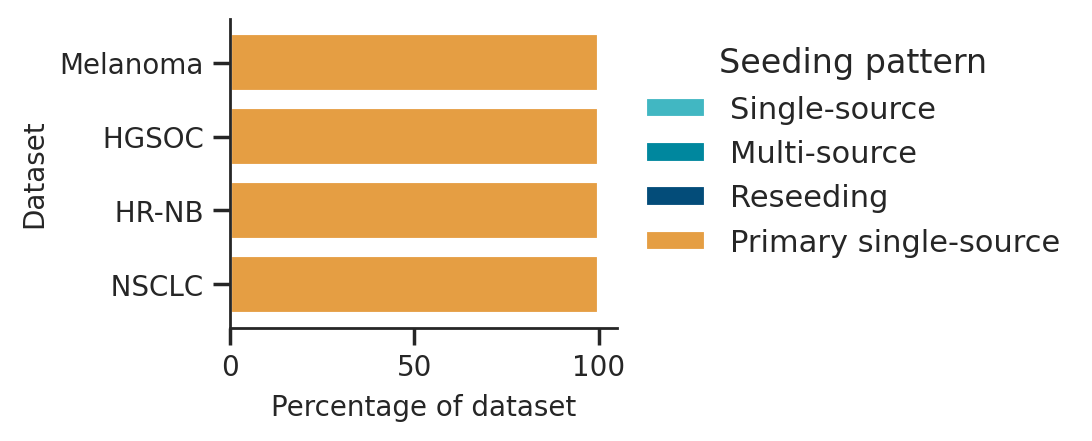

In [14]:
import numpy as np

def stacked_bar_seeding_pattern(df, key, output_name):
    df = df.copy(deep=True)
    sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.linewidth': 1.0})

    # hack to get desired order...
    dataset_map = {'Melanoma':'Melanoma', 'HGSOC':' HGSOC', 'HR-NB':'  HR-NB', 'NSCLC':'   NSCLC'}
    df['Dataset'] = df.apply(lambda row: dataset_map[row['Dataset']], axis=1)

    # Calculate the count of each category within each dataset
    category_counts = df.groupby(['Dataset', key]).size().unstack(fill_value=0)

    # Calculate proportions
    category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)*100
    for ptrn in desired_order:
        if ptrn not in category_proportions.columns: # the seeding pattern never shows up
            category_proportions[ptrn] = 0.0
    print(category_proportions.columns, category_proportions)
    fig, ax = plt.subplots(figsize=(2.5,2), dpi=200)

    # Variables to store the bottom for each bar
    bottoms = np.zeros(len(category_proportions))

    # Colors for each category
    tab_colors = ["#41b7c2", "#00879e", "#034c79", "#e59e43",]
    colors = {d:c for d,c in zip(desired_order, tab_colors)}
    sns.set(style='ticks', font="Arial")
    # Plot each category
    for column_name in desired_order:
        column_data = category_proportions[column_name]
        ax.barh(category_proportions.index, column_data,left=bottoms, label=column_name, 
               color=colors[column_name], edgecolor='white', linewidth=1.5)
        bottoms += column_data.values


    ax.set_xlabel('Percentage of dataset')
    ax.set_ylabel('Dataset')
    legend = ax.legend(title='Seeding pattern', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)  # Place legend outside the plot
    for text in legend.get_texts():
        text.set_text(text.get_text().capitalize())


    # Remove top and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{output_name}_distribution.png"), dpi=300,  bbox_inches='tight', pad_inches=0.05)
    plt.show()

df = trees_df[trees_df['Dataset']!='Breast Cancer']
# df = df[df['Num sites']>2]
stacked_bar_seeding_pattern(df, 'Top cal seeding pattern', 'stacked_bar_top_cal_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest mig seeding pattern', 'stacked_bar_lowest_mig_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest comig seeding pattern', 'stacked_bar_lowest_comig_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest ss seeding pattern', 'stacked_bar_lowest_ss_seeding_pattern')


### Compare the distribution of the models

Seeding pattern                  Multi-source  Primary single-source  \
Model                                                                  
Metient-calibrate                       1.796                 88.623   
Migration \npenalizing model            2.994                 83.234   
Seeding site \npenalizing model         0.000                100.000   

Seeding pattern                  Reseeding  Single-source  
Model                                                      
Metient-calibrate                    0.599          8.982  
Migration \npenalizing model         4.790          8.982  
Seeding site \npenalizing model      0.000          0.000  


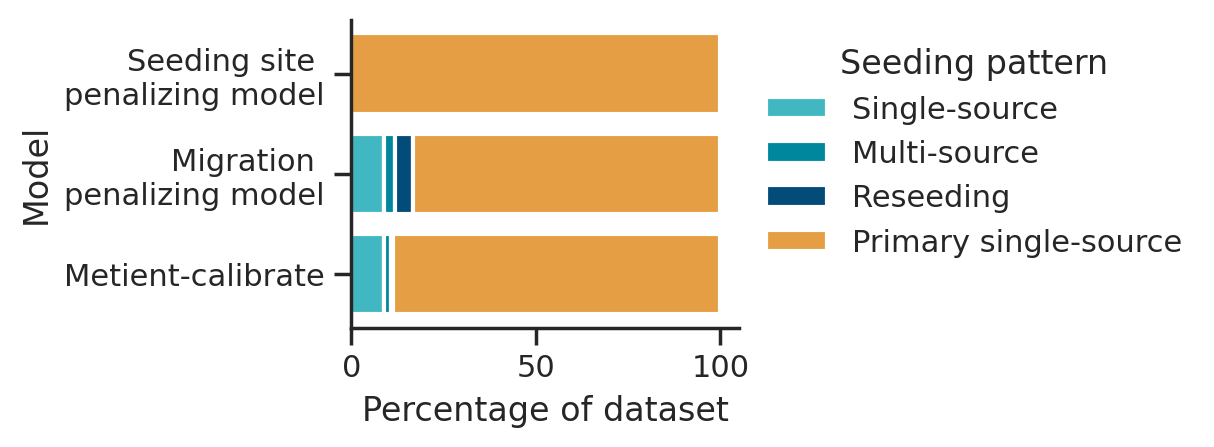

In [15]:
data = []
keys = ['Top cal seeding pattern', 'Lowest ss seeding pattern', 'Lowest mig seeding pattern',]
model_name_map = {"Top cal":"Metient-calibrate", "Lowest ss":"Seeding site \npenalizing model", "Lowest mig":"Migration \npenalizing model"}

for i, row in trees_df.iterrows():
    for key in keys:
        pattern = 'Primary single-source' if row[key] == 'primary single-source' else 'Not primary single-source'
        pattern = row[key].capitalize()
        data.append([model_name_map[key.replace(" seeding pattern", "")],pattern])
model_df = pd.DataFrame(data, columns = ["Model", "Seeding pattern"])
proportion_df = model_df.groupby(['Model', 'Seeding pattern']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='Proportion')
category_proportions = proportion_df.pivot(index='Model', columns='Seeding pattern', values='Proportion').fillna(0)
print(category_proportions)

bottoms = np.zeros(len(category_proportions))
fig, ax = plt.subplots(figsize=(2.5,2),dpi=200)
#desired_order_general = ['Primary single-source', 'Not primary single-source']
desired_order_general = ['Single-source', 'Multi-source', 'Reseeding', 'Primary single-source']

#tab_colors = [ "#e59e43","#00879e", ]
tab_colors = ["#41b7c2", "#00879e", "#034c79", "#e59e43",]
colors = {d:c for d,c in zip(desired_order_general, tab_colors)}
sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 11, 'xtick.labelsize': 10, 'ytick.labelsize': 9, 'axes.linewidth': 1.0})
# Plot each category
for column_name in desired_order_general:
    column_data = category_proportions[column_name]
    ax.barh(category_proportions.index, column_data,left=bottoms, label=column_name, 
           color=colors[column_name], edgecolor='white', linewidth=1.5)
    bottoms += column_data.values

ax.set_xlabel('Percentage of dataset')
ax.set_ylabel('Model')
legend = ax.legend(title='Seeding pattern', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)  # Place legend outside the plot
for text in legend.get_texts():
    text.set_text(text.get_text().capitalize())

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR, "model_comparison_distribution.png"), dpi=300,  bbox_inches='tight', pad_inches=0.05)
plt.show()

Top cal % migs poly
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=5.270e-02 stat=2.150e+00
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=7.923e-01 stat=-2.708e-01
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=1.249e-01 stat=1.570e+00
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=3.316e-02 stat=2.470e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=5.873e-01 stat=5.701e-01
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=8.573e-03 stat=3.655e+00


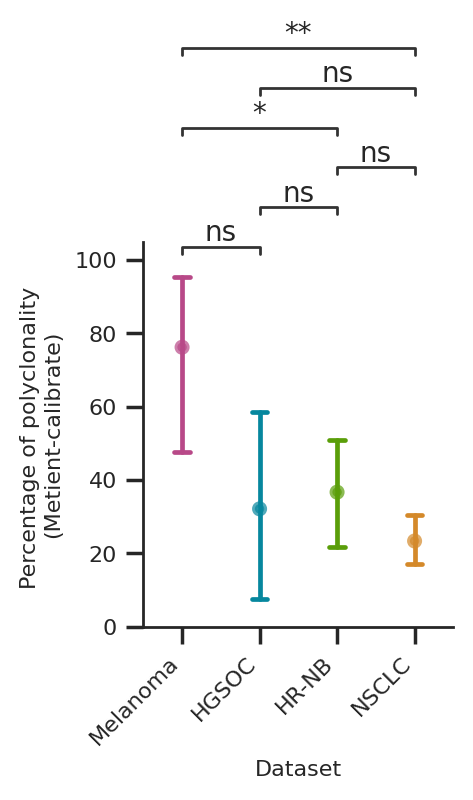

Top cal % metastatic sites
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=nan stat=nan
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=4.595e-02 stat=-2.096e+00
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=5.973e-01 stat=5.332e-01
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=4.595e-02 stat=-2.096e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=1.769e-04 stat=-3.866e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.769e-04 stat=-3.866e+00


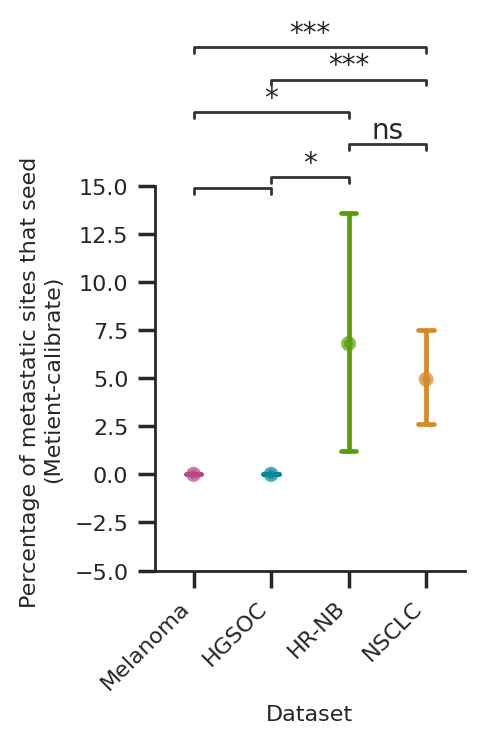

Top cal num ss
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=nan stat=nan
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=4.312e-02 stat=-2.126e+00
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=9.737e-01 stat=-3.310e-02


/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/statannot/statannot.py:109: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = stats.ttest_ind(


Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=4.312e-02 stat=-2.126e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=1.861e-04 stat=-3.852e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.861e-04 stat=-3.852e+00


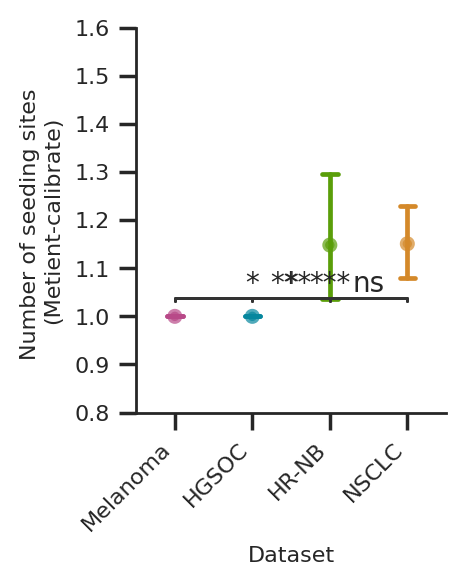

In [16]:
from statannot import add_stat_annotation
import itertools

def point_plot_comparing_datasets(df, key, ylim, ylabel, output_name, with_stat,offset=0.02):
    df = df.copy(deep=True)
    print(key)
    
    sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})

    fig = plt.figure(figsize=(2,2.5), dpi=200)
    order = ['Melanoma','HGSOC','HR-NB', 'NSCLC' ]
    #colors =  [sns.color_palette("Set1")[1],sns.color_palette("Set1")[2], sns.color_palette("Set1")[0],(0.5, 0.5, 0.5)]
    snsfig = sns.pointplot(data=df, x='Dataset', y=key, errwidth=1.7, order=order,
                           dodge=True, markers='.', errorbar='se', palette=four_dataset_colors.values(), capsize=0.2)
  
    if with_stat:
        
        add_stat_annotation(snsfig, data=df, x='Dataset', y=key,
                            box_pairs=itertools.combinations(order, 2),order=order, line_offset=offset,
                            test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.1, 
                            text_offset=0.01, verbose=2,  fontsize=10, comparisons_correction=None,linewidth=1.0,
                            )
        
    snsfig.set_xticklabels(snsfig.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.xlabel("Dataset", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{output_name}_distribution.png"), dpi=500,  bbox_inches='tight', pad_inches=0.1)

    plt.show()
    plt.close()
    
no_bc_df = trees_df[trees_df['Dataset']!='Breast Cancer']
point_plot_comparing_datasets(no_bc_df, 'Top cal % migs poly',(0,105), "Percentage of polyclonality \n(Metient-calibrate)", 'num_migs_poly_calibrate_bw_datasets', True)
point_plot_comparing_datasets(no_bc_df, 'Top cal % metastatic sites',(-5,15), "Percentage of metastatic sites that seed \n(Metient-calibrate)", 'num_sites_metastasize_bw_datasets', True)
# point_plot_clonality(df, 'Lowest mig % migs poly', 'blah')
# point_plot_clonality(df, 'Lowest comig % migs poly', 'blah')
#point_plot_comparing_datasets(df, 'Lowest ss % migs poly', (0.3,1.1),"Fraction of migrations \nthat are polyclonal",'blah', True)
point_plot_comparing_datasets(no_bc_df, 'Top cal num ss', (0.8,1.6),"Number of seeding sites \n(Metient-calibrate)", 'num_ss_calibrate_bw_datasets', True, offset=0.1)



### Whats the percentage of metastatic sites that seed vs. the number of polyclonal migrations

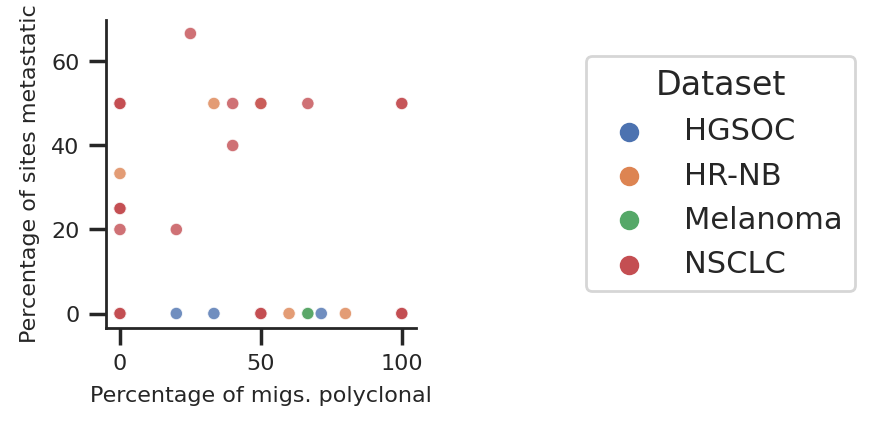

In [17]:
no_bc_df = no_bc_df.copy(deep=True)   
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
fig = plt.figure(figsize=(2,2), dpi=200)

snsfig = sns.scatterplot(x=no_bc_df['Top cal % migs poly'], y=no_bc_df['Top cal % metastatic sites'], 
                         hue='Dataset', data=df, s=20)

snsfig.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), title='Dataset')
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.setp(snsfig.collections, alpha=0.8)
plt.xlabel("Percentage of migs. polyclonal", fontsize=8)
plt.ylabel("Percentage of sites metastatic", fontsize=8)
#plt.savefig(os.path.join(OUTPUT_DIR,f"scatter_plot_ssmodel_vs_calmodel_percent_polyclonal.png"), dpi=500,  bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

                      Type   Value
0    Lowest ss % migs poly  33.333
1    Lowest ss % migs poly 100.000
2    Lowest ss % migs poly   0.000
3    Lowest ss % migs poly  71.429
4    Lowest ss % migs poly   0.000
..                     ...     ...
329    Top cal % migs poly   0.000
330    Top cal % migs poly   0.000
331    Top cal % migs poly   0.000
332    Top cal % migs poly   0.000
333    Top cal % migs poly   0.000

[334 rows x 2 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lowest ss % migs poly v.s. Top cal % migs poly: t-test paired samples, P_val=6.665e-05 stat=4.092e+00


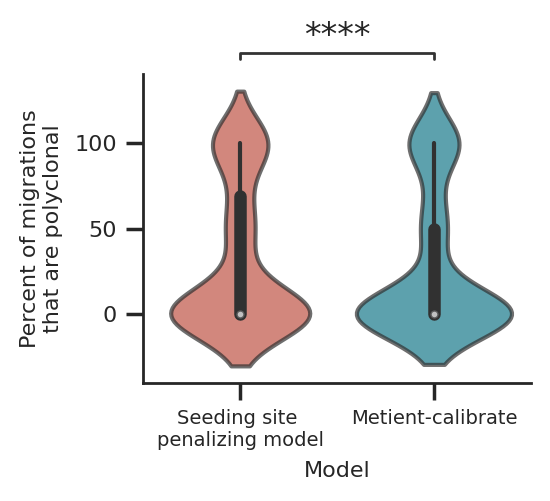

                 Type  Value
0    Lowest ss num ss      1
1    Lowest ss num ss      1
2    Lowest ss num ss      1
3    Lowest ss num ss      1
4    Lowest ss num ss      1
..                ...    ...
329    Top cal num ss      1
330    Top cal num ss      1
331    Top cal num ss      2
332    Top cal num ss      1
333    Top cal num ss      1

[334 rows x 2 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lowest ss num ss v.s. Top cal num ss: t-test paired samples, P_val=2.403e-05 stat=-4.347e+00


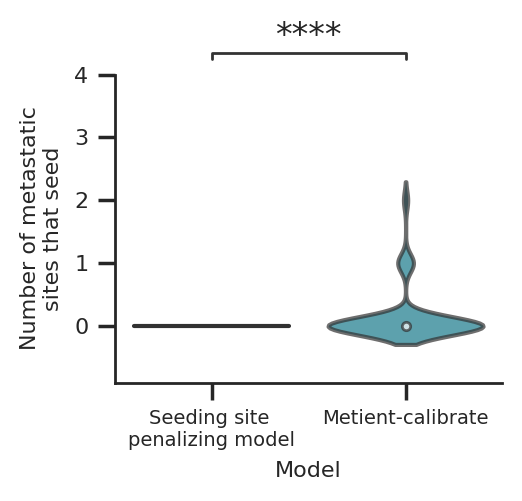

In [18]:
def violin_plot_comparison(df, keys,ylim, ylabel,output_name,subtract_one=False,):
    df = df.copy(deep=True)
    df_long = df.melt(value_vars=keys, var_name='Type', value_name='Value')
    print(df_long)
    if subtract_one: # for metastatic seeding sites vs all seeding sites
        df_long['Value'] = df_long['Value'] - 1
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2.5,2), dpi=200)
    
    types = df_long['Type'].unique()
    colors = ["#d44432", "#06879e"]
 
    snsfig = sns.violinplot(data=df_long, x='Type', y='Value', 
                           dodge=True, palette=colors)
    snsfig.set_xticklabels(['Seeding site \npenalizing model', 'Metient-calibrate'], rotation=0, fontsize=7)

    plt.xlabel("Model", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    add_stat_annotation(snsfig, data=df_long, x='Type', y="Value",
                        box_pairs=[keys], line_offset=0.05,
                        test='t-test_paired', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                        text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                        )    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_violinplot_ssmodel_vs_calmodel.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

violin_plot_comparison(no_bc_df, ['Lowest ss % migs poly', 'Top cal % migs poly'],(-40,140),"Percent of migrations\nthat are polyclonal","percent_polyclonal")
violin_plot_comparison(no_bc_df, ['Lowest ss num ss', 'Top cal num ss'],(-0.9,4),"Number of metastatic\nsites that seed", "number_met_ss",subtract_one=True, )



                         Dataset                   Type   Value
0    HGSOC Lowest ss % migs poly  Lowest ss % migs poly  33.333
1    HGSOC Lowest ss % migs poly  Lowest ss % migs poly 100.000
2    HGSOC Lowest ss % migs poly  Lowest ss % migs poly   0.000
3    HGSOC Lowest ss % migs poly  Lowest ss % migs poly  71.429
4    HGSOC Lowest ss % migs poly  Lowest ss % migs poly   0.000
..                           ...                    ...     ...
329    NSCLC Top cal % migs poly    Top cal % migs poly   0.000
330    NSCLC Top cal % migs poly    Top cal % migs poly   0.000
331    NSCLC Top cal % migs poly    Top cal % migs poly   0.000
332    NSCLC Top cal % migs poly    Top cal % migs poly   0.000
333    NSCLC Top cal % migs poly    Top cal % migs poly   0.000

[334 rows x 3 columns]
[['Melanoma Lowest ss % migs poly', 'Melanoma Top cal % migs poly'], ['HGSOC Lowest ss % migs poly', 'HGSOC Top cal % migs poly'], ['HR-NB Lowest ss % migs poly', 'HR-NB Top cal % migs poly'], ['NSCLC Lowest 

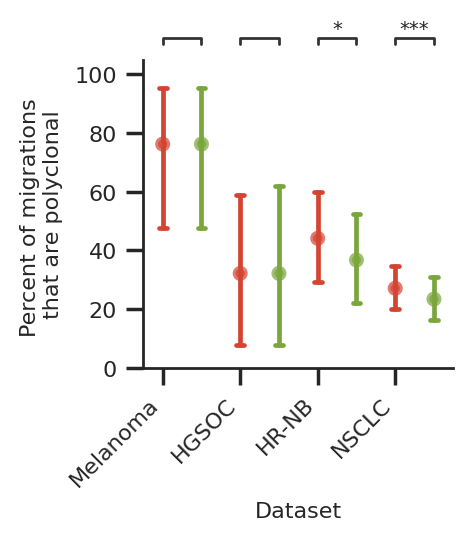

                    Dataset              Type  Value
0    HGSOC Lowest ss num ss  Lowest ss num ss      1
1    HGSOC Lowest ss num ss  Lowest ss num ss      1
2    HGSOC Lowest ss num ss  Lowest ss num ss      1
3    HGSOC Lowest ss num ss  Lowest ss num ss      1
4    HGSOC Lowest ss num ss  Lowest ss num ss      1
..                      ...               ...    ...
329    NSCLC Top cal num ss    Top cal num ss      1
330    NSCLC Top cal num ss    Top cal num ss      1
331    NSCLC Top cal num ss    Top cal num ss      2
332    NSCLC Top cal num ss    Top cal num ss      1
333    NSCLC Top cal num ss    Top cal num ss      1

[334 rows x 3 columns]
[['Melanoma Lowest ss num ss', 'Melanoma Top cal num ss'], ['HGSOC Lowest ss num ss', 'HGSOC Top cal num ss'], ['HR-NB Lowest ss num ss', 'HR-NB Top cal num ss'], ['NSCLC Lowest ss num ss', 'NSCLC Top cal num ss']]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-0

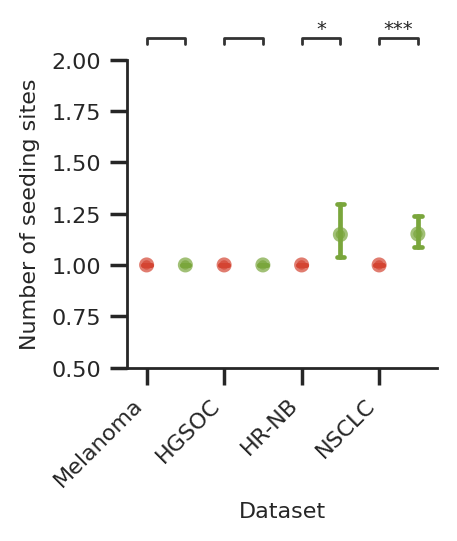

In [19]:

def point_plot_comparison(df, keys, ylim, ylabel, output_name, with_stats=True):
    df = df.copy(deep=True)
    df_long = df.melt(id_vars='Dataset', value_vars=keys, var_name='Type', value_name='Value')
    df_long['Dataset'] = df_long.apply(lambda row: f"{row['Dataset']} {row['Type']}", axis=1)
    print(df_long)
    sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})

    fig = plt.figure(figsize=(2,2), dpi=200)
    
    types = df_long['Type'].unique()
    order = ['Melanoma','HGSOC','HR-NB', 'NSCLC']
    full_order = []
    colors = ["#d44432", "#7aa63c"]*len(order)
    groups = []
    for o in order:
        group = []
        for t in types:
            full_order.append(f"{o} {t}")
            group.append(f"{o} {t}")
        groups.append(group)
    print(groups)
    snsfig = sns.pointplot(data=df_long, x='Dataset', y='Value', s=5, errwidth=1.7, order=full_order,
                           dodge=True, markers='.', errorbar='se', palette=colors, capsize=0.2)
    plt.xlabel("Dataset", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    if with_stats:
        add_stat_annotation(snsfig, data=df_long, x='Dataset', y="Value",
                            box_pairs=groups,order=full_order, line_offset=0.05,
                            test='t-test_paired', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
    plt.xticks([x for x in range(0,len(order)*2,2)], order, rotation=45,horizontalalignment='right')
    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_distribution.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()

point_plot_comparison(no_bc_df, ['Lowest ss % migs poly', 'Top cal % migs poly'], (0,105), "Percent of migrations \nthat are polyclonal", 'num_migs_poly_calibrate_vs_lowest_ss')
point_plot_comparison(no_bc_df, ['Lowest ss num ss', 'Top cal num ss'], (0.5,2.0), "Number of seeding sites",'num_ss_calibrate_vs_lowest_ss', with_stats=True)


['#d4892a', '#5a9e09', '#b84988', '#06879e']


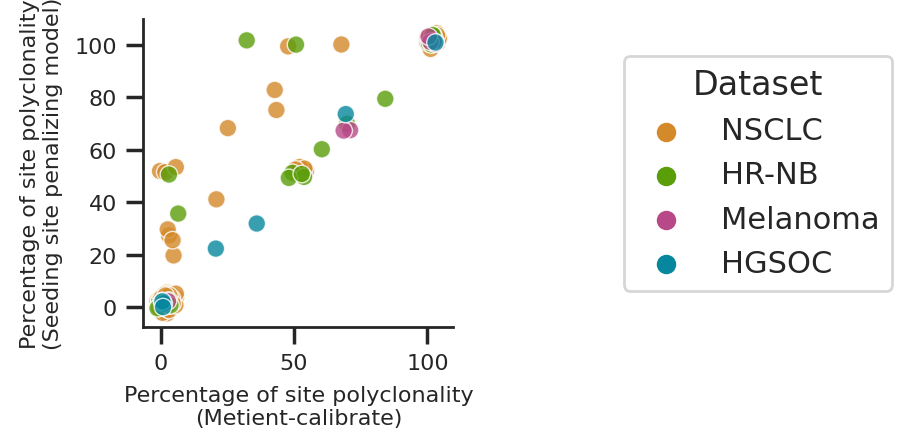

<Figure size 400x400 with 0 Axes>

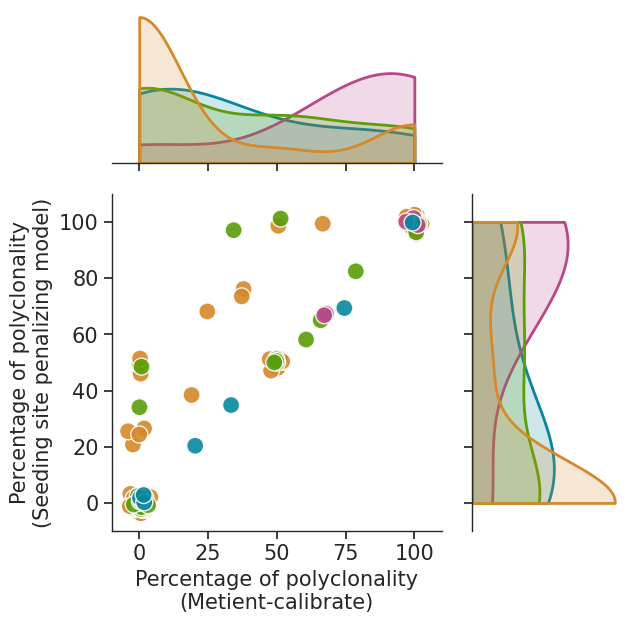

In [20]:

dataset_order = ['NSCLC','HR-NB','Melanoma','HGSOC']
colors = [four_dataset_colors[d] for d in dataset_order]
print(colors)
def joint_plot(df, keys, output_name, split_by_dataset):
    df = df.copy(deep=True)   
    sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2,2), dpi=200)
    df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)
    # Sort the DataFrame based on the custom order of the 'Department' column
    df = df.sort_values(by='Dataset')
    
    hue = 'Dataset' if split_by_dataset else None
    g = sns.JointGrid(data=df, x=jitter(df[keys[0]], 0), y=jitter(df[keys[1]], 0), 
                      hue=hue, palette=colors, ratio=2, xlim=(-10,110), ylim=(-10,110))
    g.plot_joint(sns.scatterplot, s=150, alpha=0.9, hue=hue,palette=colors)
    g.plot_marginals(sns.kdeplot, common_norm=False, hue=hue,palette=colors, 
                     shade=True,clip=(0,100), linewidth=2, alpha=0.2,)
    g.set_axis_labels("Percentage of polyclonality\n(Metient-calibrate)", "Percentage of polyclonality\n(Seeding site penalizing model)",fontsize=15)
    g.ax_joint.tick_params(axis='both', labelsize=15)
    g.ax_marg_x.spines['left'].set_linewidth(2)

    g.ax_joint.legend_.remove()

    plt.savefig(os.path.join(OUTPUT_DIR,f"joint_plot_ssmodel_vs_calmodel_percent_polyclonal.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

def jitter(values,j):
    return values + np.random.normal(j,1.5,values.shape)

def scatter_plot_comparison(df, keys, output_name): 
    df = df.copy(deep=True)   
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2,2), dpi=200)
    df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)
    # Sort the DataFrame based on the custom order of the 'Department' column
    df = df.sort_values(by='Dataset')
    snsfig = sns.scatterplot(x=jitter(df[keys[0]], 2), y=jitter(df[keys[1]], 2), 
                             hue='Dataset', data=df, s=40,palette=colors)
    
    snsfig.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), title='Dataset')
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.8)
    plt.xlabel("Percentage of site polyclonality\n(Metient-calibrate)", fontsize=8)
    plt.ylabel("Percentage of site polyclonality\n(Seeding site penalizing model)", fontsize=8)
    plt.savefig(os.path.join(OUTPUT_DIR,f"scatter_plot_ssmodel_vs_calmodel_percent_polyclonal.png"), dpi=500,  bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

scatter_plot_comparison(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah')
#scatter_hist_model_comparison(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah')
joint_plot(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah', True)


### Are there any significant differences between LUSC and LUAD subtypes?

['LUAD' 'LUSC']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LUAD v.s. LUSC: Welch's t-test independent samples, P_val=7.865e-01 stat=-2.717e-01


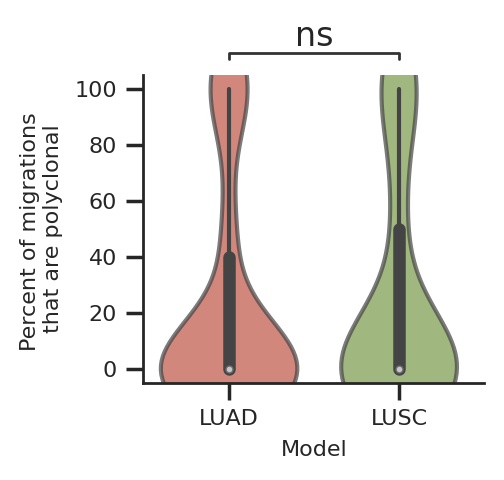

['LUAD' 'LUSC']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LUAD v.s. LUSC: Welch's t-test independent samples, P_val=9.795e-01 stat=-2.582e-02


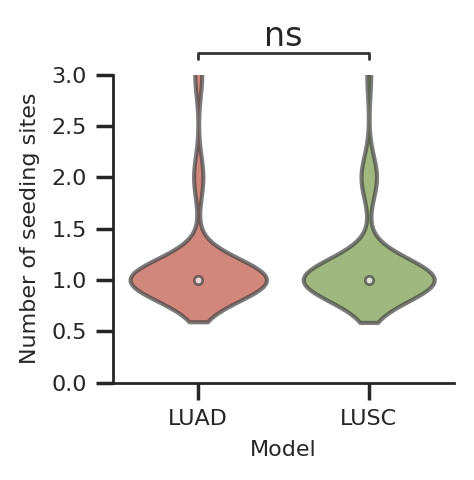

In [21]:

def box_plot_comparison_nsclc_subtypes(df, y,ylim,ylabel,output_name):
    
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2.2,2), dpi=200)
    
    colors = ["#d44432", "#7aa63c"]
 
    snsfig = sns.violinplot(data=df, x='Subtype', y=y, 
                           dodge=True, palette=colors)
#     snsfig.set_xticklabels(['Seeding site \npenalizing model', 'Metient-calibrate'], rotation=0, fontsize=7)

    plt.xlabel("Model", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    subtypes = nsclc_subset['Subtype'].unique()
    print(subtypes)
    add_stat_annotation(snsfig, data=df, x='Subtype', y=y,
                        box_pairs=[subtypes], line_offset=0.05,
                        test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                        text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                        )    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_boxplot_ssmodel_vs_calmodel.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()


nsclc_subset = trees_df[(trees_df['Dataset']=='NSCLC') & (trees_df['Subtype']!='N/A')]
box_plot_comparison_nsclc_subtypes(nsclc_subset, "Top cal % migs poly", (-5,105), "Percent of migrations \nthat are polyclonal", 'num_migs_poly_calibrate_vs_lowest_ss')

box_plot_comparison_nsclc_subtypes(nsclc_subset, "Top cal num ss", (0,3), "Number of seeding sites", 'num_migs_poly_calibrate_vs_lowest_ss')



### What would the seeding pattern distributions be if we adopted the tie breaking model? (minimize migration # first, then comigration then seeding site)

In [22]:
data = []
for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):

    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print("\n", dataset, len(patients))
    patterns = []
    for patient, fn in zip(patients, matching_files):
        pars_metrics = []
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            for l in loss_dicts:
                pars_metrics.append((int(l[MIG_KEY]), int(l[COMIG_KEY]), int(l[SEEDING_KEY])))
            
            sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][0], x[1][1], x[1][2]))
            best_index = sorted_indices[0][0]
            if best_index != 0: 
                print("Different result:", dataset, patient)
            V = torch.tensor(pkl[OUT_LABElING_KEY][best_index])
            A = torch.tensor(pkl[OUT_ADJ_KEY][best_index])
                
            pattern = putil.seeding_pattern(V,A)
            patterns.append(pattern)
            data.append([dataset, desired_order.index(pattern)])
    print(set(patterns))
    
    counts = Counter({p: 0 for p in desired_order})
    # Update counts with actual counts from data
    counts.update(patterns)
    print(counts)

tie_scheme_df = pd.DataFrame(data, columns=['Dataset', 'Seeding pattern'])



 Breast Cancer 0
set()
Counter({'single-source': 0, 'multi-source': 0, 'reseeding': 0, 'primary single-source': 0})

 HGSOC 13
Different result: HGSOC 3
{'reseeding', 'single-source', 'primary single-source'}
Counter({'primary single-source': 10, 'single-source': 2, 'reseeding': 1, 'multi-source': 0})

 Melanoma 7
Different result: Melanoma E
Different result: Melanoma B
{'reseeding', 'primary single-source'}
Counter({'primary single-source': 5, 'reseeding': 2, 'single-source': 0, 'multi-source': 0})

 HR-NB 30
Different result: HR-NB H134821
Different result: HR-NB H103207
Different result: HR-NB H118706
{'reseeding', 'single-source', 'primary single-source', 'multi-source'}
Counter({'primary single-source': 22, 'single-source': 3, 'reseeding': 3, 'multi-source': 2})

 NSCLC 128
Different result: NSCLC CRUK0495
Different result: NSCLC CRUK0311
Different result: NSCLC CRUK0748
Different result: NSCLC CRUK0290
Different result: NSCLC CRUK0465
Different result: NSCLC CRUK0245
{'reseedin

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Distant v.s. Lymph node: Welch's t-test independent samples, P_val=5.167e-01 stat=6.492e-01


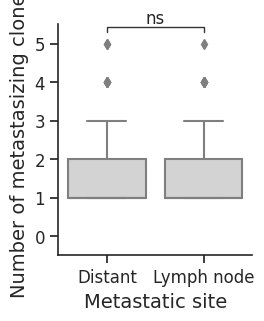

34     1
38     4
40     3
55     1
60     1
      ..
309    1
310    1
311    1
312    1
315    1
Name: Number of metastasizing clones, Length: 157, dtype: int64


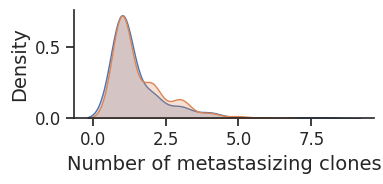

In [23]:

met_site_to_polyclonal_data = []

for fn,dataset in zip(trees_df['Filename'], trees_df['Dataset']):
    with gzip.open(fn, 'rb') as f:
        pkl = pickle.load(f)

        # Best calibrated tree
        V = torch.tensor(pkl[OUT_LABElING_KEY][0])
        A = torch.tensor(pkl[OUT_ADJ_KEY][0])
        sites = pkl[OUT_SITES_KEY]
        primary_site = pkl[OUT_PRIMARY_KEY]
        G = putil.migration_graph(V,A)

        for i,seeding_site in enumerate(sites):
            for j, seeded_site in enumerate(sites):
                if i == j or G[i,j] == 0: 
                    continue
                is_polyclonal = int(G[i,j]>1)
                category = "Lymph node" if is_ln(seeded_site) else "Distant"
                met_site_to_polyclonal_data.append([dataset, os.path.basename(fn).replace(".pkl.gz", ""), category, is_polyclonal, int(G[i,j])])

met_site_to_polyclonal_df = pd.DataFrame(data=met_site_to_polyclonal_data, columns=["Dataset", "Patient", "Metastatic site", "Is polyclonal", "Number of metastasizing clones"])

fig = plt.figure(figsize=(2.5,3))
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.linewidth': 1.2})

colors = ["lightgrey", "lightgrey"]

snsfig = sns.boxplot(data=met_site_to_polyclonal_df, x='Metastatic site', y="Number of metastasizing clones", 
                       dodge=True, palette=colors)
plt.xlabel("Metastatic site")
plt.ylabel("Number of metastasizing clones")
plt.ylim(-0.5,5.5)
subtypes = met_site_to_polyclonal_df["Metastatic site"].unique()
add_stat_annotation(snsfig, data=met_site_to_polyclonal_df, x='Metastatic site', y="Number of metastasizing clones",
                    box_pairs=[subtypes], line_offset=0.05,
                    test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                    text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                    )    
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR,f"num_met_clones_ln_vs_other_boxplot.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()


fig, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.linewidth': 1.2})
ln_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Lymph node']
distant_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Distant']
print(ln_df["Number of metastasizing clones"])
sns.kdeplot(ln_df["Number of metastasizing clones"], ax=ax, fill=True)
snsfig= sns.kdeplot(distant_df["Number of metastasizing clones"], ax=ax, fill=True)

snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### What are the percentages of polcylonal metastases to the lymph, to distant?

In [24]:
distant_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Distant']
print("Distant mets polyclonality:\n", distant_df['Is polyclonal'].value_counts())
ln_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Lymph node']
print("LN mets polyclonality:\n", ln_df['Is polyclonal'].value_counts())


Distant mets polyclonality:
 0    100
1     59
Name: Is polyclonal, dtype: int64
LN mets polyclonality:
 0    111
1     46
Name: Is polyclonal, dtype: int64


### Distribution of each dataset's polyclonal migrations, lymph node vs. distant met

HGSOC nan 1.5384615384615385
HR-NB 2.3 1.8
Melanoma 2.25 2.25
NSCLC 1.4615384615384615 1.375


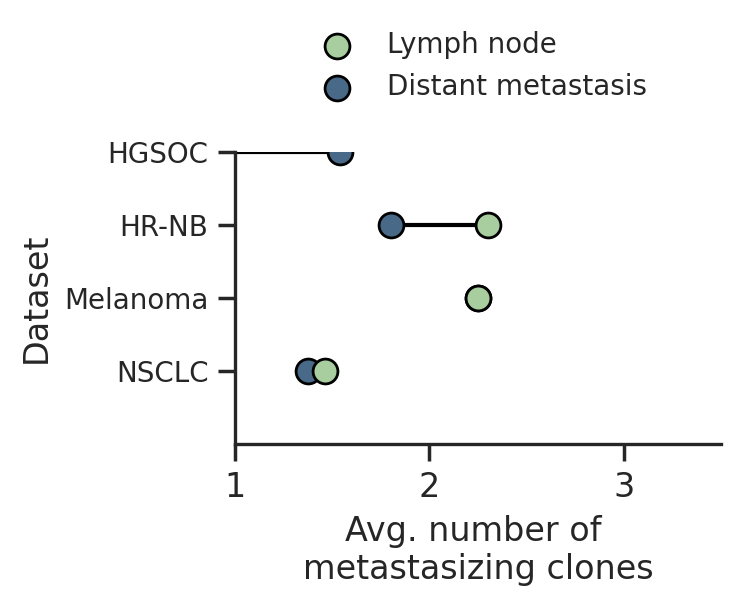

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

data = []

j = len(met_site_to_polyclonal_df['Dataset'].unique()) - 1
for i, dataset in enumerate(met_site_to_polyclonal_df['Dataset'].unique()):
    sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 10, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.linewidth': 1.2})
    dataset_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Dataset']==dataset]
    ln_clones = dataset_df[(dataset_df['Metastatic site']=='Lymph node')]["Number of metastasizing clones"]
    distant_clones = dataset_df[(dataset_df['Metastatic site']=='Distant')]["Number of metastasizing clones"]
    ln_clones_mean = ln_clones.mean() if len(ln_clones) > 0 else 0.0
    distant_clones_mean = distant_clones.mean() if len(distant_clones) > 0 else 0.0
    print(dataset, ln_clones.mean(), distant_clones.mean())
    p1 = plt.scatter(ln_clones_mean, j, c='#A8CD9F', s=80, zorder=3, ec='black', label='Lymph node')
    plt.scatter(distant_clones_mean, j, c='#496989', s=80, zorder=2, ec='black', label='Distant')
    plt.plot((ln_clones_mean, distant_clones_mean), (j, j), c='black', zorder=1, alpha=1, linewidth=1.5)
    plt.xlim((1,3.5))
    plt.ylim((-1,2.5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    j -= 1

plt.yticks([3,2, 1, 0], met_site_to_polyclonal_df['Dataset'].unique(), fontsize=10)
plt.xlabel("Avg. number of \nmetastasizing clones", fontsize=12)
plt.ylabel("Dataset", fontsize=12)

legend_labels = ['Lymph node', 'Distant metastasis']
plt.legend(legend_labels, loc='upper center',  bbox_to_anchor=(0.5, 1.5), ncol=1, 
           frameon=False, fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,f"avg_num_met_clones.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)

plt.show()

['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Lymph node']
['Distant']
['Distant']
['Distant']
['Lymph node' 'Distant']
['Lymph node' 'Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant' 'Lymph node']
['Distant']
['Distant' 'Lymph node']
['Lymph node']
['Distant']
['Distant']
['Distant']
['Distant']
['Distant' 'Lymph node']
['Distant']
['Distant']
['Lymph node' 'Distant']
['Distant']
['Lymph node' 'Distant']
['Distant' 'Lymph node']
['Lymph node' 'Distant']
['Distant']
['Lymph node']
['Distant']
['Lymph node']
['Lymph node' 'Distant']
['Lymph node']
['Lymph node']
['Lymph node']
['Lymph node' 'Distant']
['Lymph node' 'Distant']
['Distant']
['Distant']
['Distant']
['Distant']
['Lymph node']
['Lymph node' 'Distant']
['Distant']
['Lymph node']
['Distant']
['Lymph node']
['Lymph node']
['Distant']
['Lymph node']
['Distant']
['Lymph node']
['Lymph node

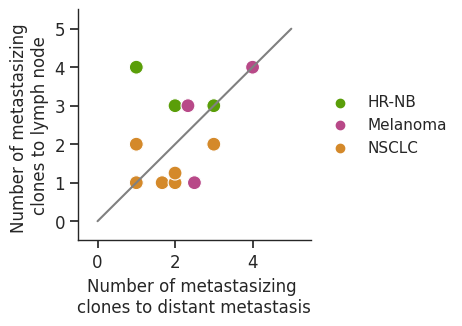

In [26]:
import math
patients = met_site_to_polyclonal_df['Patient'].unique()
ln_avg_num_clones = []
other_met_avg_num_clones = []
ct = 0
paired_data_num_met_clones = []
datasets = []
for patient in patients:
    pt_subset = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Patient']==patient]
    print(pt_subset['Metastatic site'].unique())
    ln_avg = pt_subset[pt_subset['Metastatic site']=='Lymph node']['Number of metastasizing clones'].mean()
    other_avg = pt_subset[pt_subset['Metastatic site']=='Distant']['Number of metastasizing clones'].mean()
    if not math.isnan(ln_avg) and  not math.isnan(other_avg):
        #print(pt_subset, ln_avg, other_avg)
        ln_avg_num_clones.append(ln_avg)
        other_met_avg_num_clones.append(other_avg)
        dataset = pt_subset['Dataset'].unique().item()
        paired_data_num_met_clones.append([patient, dataset, ln_avg, other_avg])
        ct += 1

sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.linewidth': 1.0})
plt.figure(figsize=(3, 3))
paired_df = pd.DataFrame(paired_data_num_met_clones, columns=["Patient", "Dataset", "LN average", "Other met average"])
datasets = paired_df['Dataset'].unique()
snsfig = sns.scatterplot(data=paired_df, x="Other met average",y="LN average", hue="Dataset",
                         s=100, palette=[four_dataset_colors[d] for d in datasets], alpha=1.0, edgecolors='face', linewidths=4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.plot([0, 5], [0, 5],color='grey')
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.xlabel("Number of metastasizing \nclones to distant metastasis", fontsize=12)
plt.ylabel("Number of metastasizing \nclones to lymph node", fontsize=12)
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.savefig(os.path.join(OUTPUT_DIR,f"num_met_clones_ln_vs_other_scatterplot.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [27]:
import scipy.stats as stats 
  
# paired sample t-test 
s = stats.ttest_rel(paired_df['LN average'], paired_df['Other met average']) 
s.pvalue

0.9562549394725048

0.2929936305732484 0.3710691823899371
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Distant v.s. Lymph node: Welch's t-test independent samples, P_val=1.414e-01 stat=1.474e+00
0.0 29.89936305732484
1.0 37.70691823899371


/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


157 46/157
159 59/159


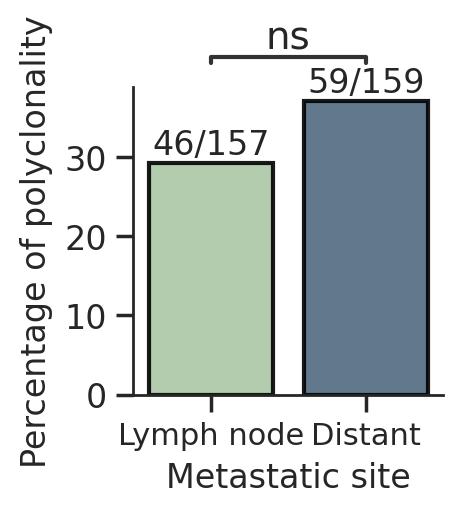

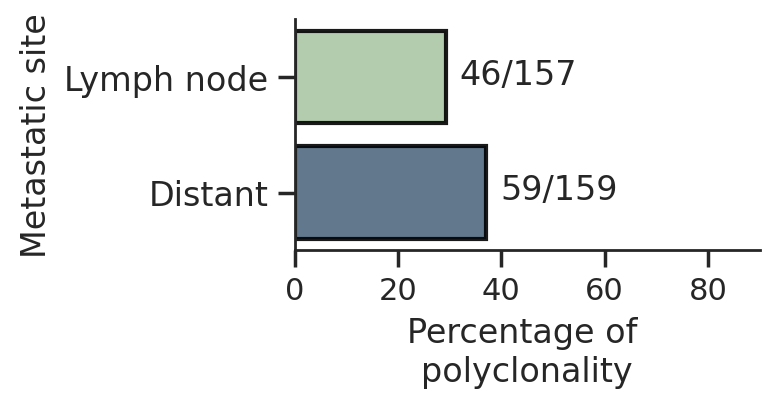

In [28]:
ln_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Lymph node']
other_df = met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Distant']
ln_percent = len(ln_df[ln_df['Is polyclonal']==1])/(len(ln_df[ln_df['Is polyclonal']==0])+ len(ln_df[ln_df['Is polyclonal']==1]))
other_percent = len(other_df[other_df['Is polyclonal']==1])/(len(other_df[other_df['Is polyclonal']==0])+ len(other_df[other_df['Is polyclonal']==1]))
print(ln_percent, other_percent, )

plt.figure(figsize=(2,2), dpi=200)
sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 12, 'xtick.labelsize': 11, 'ytick.labelsize': 12, 'axes.linewidth': 1.0})

snsfig = sns.barplot(['Lymph node', 'Distant'], [ln_percent*100, other_percent*100],dodge=True,
                     palette=['#A8CD9F','#496989'], alpha=0.9,edgecolor='black', linewidth=1.5,)

add_stat_annotation(snsfig, data=met_site_to_polyclonal_df,
                    x='Metastatic site', y='Is polyclonal',
                    box_pairs=[["Lymph node", "Distant"]],test='t-test_welch', text_format='star', line_offset=0.1,
                    loc='outside', line_offset_to_box=0.01, text_offset=0.01, verbose=2,  fontsize=14, 
                    comparisons_correction=None,linewidth=1.5,
                    )
for p,df in zip(snsfig.patches, [ln_df, other_df]):
    
    denom = len(df[df['Is polyclonal']==1])+len(df[df['Is polyclonal']==0])
    frac = f"{len(df[df['Is polyclonal']==1])}/{denom}"
    print(p.get_x() + p.get_width() / 2., p.get_height()+0.6)
    snsfig.annotate(frac, 
                (p.get_x() + p.get_width() / 2., p.get_height()+0.6), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points',font="Arial")
plt.xlabel("Metastatic site")
plt.ylabel("Percentage of polyclonality")
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR,f"percent_polyclonality_ln_vs_other.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)

# horizontal version
plt.figure(figsize=(3,1.5), dpi=200)
sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 12, 'xtick.labelsize': 11, 'ytick.labelsize': 12, 'axes.linewidth': 1.0})

snsfig = sns.barplot([ln_percent*100, other_percent*100],['Lymph node', 'Distant'], dodge=True,
                     palette=['#A8CD9F','#496989'], alpha=0.9,edgecolor='black', linewidth=1.5,)
for p,df in zip(snsfig.patches, [ln_df, other_df]):
    
    denom = len(df[df['Is polyclonal']==1])+len(df[df['Is polyclonal']==0])
    frac = f"{len(df[df['Is polyclonal']==1])}/{denom}"
    print( denom, frac)
    snsfig.annotate(frac, 
                (p.get_width()+14, p.get_y() + p.get_height()/2+0.1), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points',font="Arial")
plt.xlim(0,90)
plt.ylabel("Metastatic site")
plt.xlabel("Percentage of \npolyclonality")
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.savefig(os.path.join(OUTPUT_DIR,f"percent_polyclonality_ln_vs_other_horiz.png"), dpi=500,  bbox_inches='tight', pad_inches=0.05)




In [29]:
print(ln_df['Is polyclonal'].value_counts(), )
print(other_df['Is polyclonal'].value_counts())

0    111
1     46
Name: Is polyclonal, dtype: int64
0    100
1     59
Name: Is polyclonal, dtype: int64


In [30]:
met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=="Distant"]["Number of metastasizing clones"].mean()


1.610062893081761

### How often is metastatic potential poly vs monophyletic in each dataset

{'Monophyletic': '#bf7ea2', 'Polyphyletic': '#407891'}


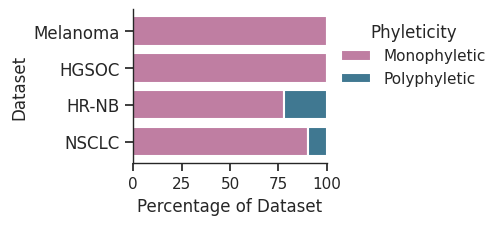

{'Monoclonal': '#bf7ea2', 'Polyclonal': '#407891'}


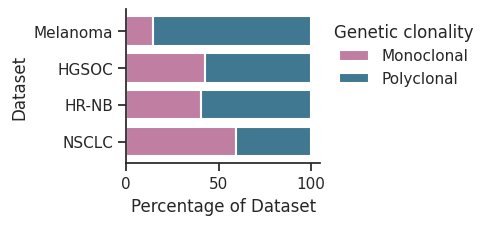

{'Monoclonal': '#bf7ea2', 'Polyclonal': '#407891'}


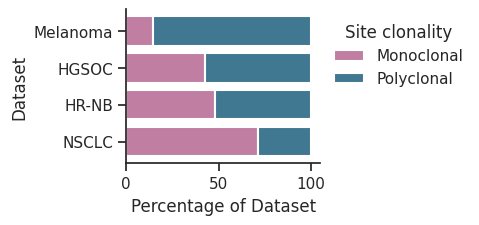

In [31]:
def horizontal_bar(proportions, desired_order, legend_title, output_name):
    fig, ax = plt.subplots(figsize=(2.5,2))

    # Variables to store the bottom for each bar
    bottoms = np.zeros(len(proportions))

    # Colors for each category
    #"#41b7c2", "#00879e",
    tab_colors = ["#bf7ea2","#407891"]
    colors = {d:c for d,c in zip(desired_order, tab_colors)}
    print(colors)
    sns.set(style='ticks', font="Arial")
    # Plot each category
    for column_name in desired_order:
        column_data = proportions[column_name]
        ax.barh(proportions.index, column_data,left=bottoms, label=column_name, 
               color=colors[column_name], edgecolor='white', linewidth=1.5)
        bottoms += column_data.values

    ax.set_xlabel('Percentage of Dataset')
    ax.set_ylabel('Dataset')
    legend = ax.legend(title=legend_title, bbox_to_anchor=(1, 1), loc='upper left', frameon=False)  # Place legend outside the plot
    for text in legend.get_texts():
        text.set_text(text.get_text().capitalize())
        
     # Remove top and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{output_name}_dataset_distribution.png"), dpi=300,  bbox_inches='tight', pad_inches=0.05)

    plt.show()
    plt.close()
    
df = trees_df[trees_df['Dataset']!='Breast Cancer']
df['Top cal phyleticity'] = df.apply(lambda row: row["Top cal phyleticity"].capitalize(), axis=1)
df['Top cal genetic clonality'] = df.apply(lambda row: row["Top cal genetic clonality"].capitalize(), axis=1)
df['Top cal site clonality'] = df.apply(lambda row: row["Top cal site clonality"].capitalize(), axis=1)

phyletic_counts = df.groupby(['Dataset', 'Top cal phyleticity']).size().unstack(fill_value=0)
phyletic_proportions = phyletic_counts.div(phyletic_counts.sum(axis=1), axis=0)*100
phyletic_proportions = phyletic_proportions.reindex(['NSCLC', "HR-NB","HGSOC", "Melanoma", ])
horizontal_bar(phyletic_proportions, ["Monophyletic", "Polyphyletic"], "Phyleticity", "phyletic")

genetic_clonality_counts = df.groupby(['Dataset', 'Top cal genetic clonality']).size().unstack(fill_value=0)
genetic_clonality_proportions = genetic_clonality_counts.div(genetic_clonality_counts.sum(axis=1), axis=0)*100
genetic_clonality_proportions = genetic_clonality_proportions.reindex(['NSCLC', "HR-NB","HGSOC", "Melanoma", ])
horizontal_bar(genetic_clonality_proportions, ["Monoclonal", "Polyclonal"], "Genetic clonality", "genetic_clonality")

site_clonality_counts = df.groupby(['Dataset', 'Top cal site clonality']).size().unstack(fill_value=0)
site_clonality_proportions = site_clonality_counts.div(site_clonality_counts.sum(axis=1), axis=0)*100
site_clonality_proportions = site_clonality_proportions.reindex(['NSCLC', "HR-NB","HGSOC", "Melanoma", ])
horizontal_bar(site_clonality_proportions, ["Monoclonal", "Polyclonal"], "Site clonality", "site_clonality")


In [32]:
df

,Dataset,Patient id,Filename,Lowest cal loss,Subtype,Num sites,Num trees on Pareto,Multiple trees w/ same pars metrics,Multiple trees w/ diff pars metrics,Root clone observed site,Top cal seeding pattern,Top cal site clonality,Top cal genetic clonality,Top cal phyleticity,Top cal tracerx phyleticity,Top cal % migs poly,Top cal num ss,Top cal seeding clusters,Top cal % metastatic sites,Lowest mig seeding pattern,Lowest mig % migs poly,Lowest mig num ss,Lowest comig seeding pattern,Lowest comig % migs poly,Lowest comig num ss,Lowest ss seeding pattern,Lowest ss % migs poly,Lowest ss num ss,Lowest ss seeding clusters,Pars metrics
0,HGSOC,1,/lila/data/morrisq/divyak/projects/metient/met...,312.983,N/A,7,4,True,False,Distant,primary single-source,Polyclonal,Polyclonal,Monophyletic,polyphyletic,33.333,1,"[0, 1, 3, 5, 7]",0.000,primary single-source,33.333,1,primary single-source,33.333,1,primary single-source,33.333,1,"[0, 1, 3, 5, 7]","[(9, 6, 1), (9, 6, 1), (9, 6, 1), (9, 6, 1)]"
1,HGSOC,10,/lila/data/morrisq/divyak/projects/metient/met...,164.570,N/A,3,1,False,False,Distant,primary single-source,Polyclonal,Polyclonal,Monophyletic,polyphyletic,100.000,1,"[0, 1, 4, 5]",0.000,primary single-source,100.000,1,primary single-source,100.000,1,primary single-source,100.000,1,"[0, 1, 4, 5]","[(5, 2, 1)]"
2,HGSOC,2,/lila/data/morrisq/divyak/projects/metient/met...,51.902,N/A,2,2,True,False,None,primary single-source,Monoclonal,Monoclonal,Monophyletic,monophyletic,0.000,1,[0],0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,[0],"[(1, 1, 1), (1, 1, 1)]"
3,HGSOC,3,/lila/data/morrisq/divyak/projects/metient/met...,447.987,N/A,8,2,True,False,Distant,primary single-source,Polyclonal,Polyclonal,Monophyletic,polyphyletic,71.429,1,"[0, 1, 2, 3, 5]",0.000,primary single-source,71.429,1,primary single-source,71.429,1,primary single-source,71.429,1,"[0, 1, 2, 3, 5]","[(14, 7, 1), (14, 7, 1)]"
4,HGSOC,4,/lila/data/morrisq/divyak/projects/metient/met...,127.859,N/A,4,1,False,False,None,primary single-source,Monoclonal,Monoclonal,Monophyletic,monophyletic,0.000,1,[1],0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,[1],"[(3, 3, 1)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,NSCLC,CRUK0794,/lila/data/morrisq/divyak/projects/metient/met...,52.372,LUAD,2,2,True,False,None,primary single-source,Monoclonal,Monoclonal,Monophyletic,monophyletic,0.000,1,[1],0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,[1],"[(1, 1, 1), (1, 1, 1)]"
163,NSCLC,CRUK0799,/lila/data/morrisq/divyak/projects/metient/met...,89.812,LUAD,3,1,False,False,None,primary single-source,Monoclonal,Polyclonal,Polyphyletic,polyphyletic,0.000,1,"[10, 12]",0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,"[10, 12]","[(2, 2, 1)]"
164,NSCLC,CRUK0810,/lila/data/morrisq/divyak/projects/metient/met...,215.466,LUAD,6,3,True,True,None,single-source,Monoclonal,Polyclonal,Monophyletic,monophyletic,0.000,2,"[0, 1, 26]",20.000,single-source,0.000,2,single-source,0.000,2,primary single-source,20.000,1,"[1, 25, 26]","[(5, 5, 2), (5, 5, 2), (6, 5, 1)]"
165,NSCLC,CRUK0817,/lila/data/morrisq/divyak/projects/metient/met...,51.369,LUAD,2,1,False,False,None,primary single-source,Monoclonal,Monoclonal,Monophyletic,monophyletic,0.000,1,[2],0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,[2],"[(1, 1, 1)]"


In [33]:
df['Top cal site clonality']

0      Polyclonal
1      Polyclonal
2      Monoclonal
3      Polyclonal
4      Monoclonal
          ...    
162    Monoclonal
163    Monoclonal
164    Monoclonal
165    Monoclonal
166    Monoclonal
Name: Top cal site clonality, Length: 167, dtype: object

In [34]:
phyletic_counts

Top cal phyleticity,Monophyletic,Polyphyletic
Dataset,,
HGSOC,7,0
HR-NB,21,6
Melanoma,7,0
NSCLC,114,12


In [35]:
genetic_clonality_counts

Top cal genetic clonality,Monoclonal,Polyclonal
Dataset,,
HGSOC,3,4
HR-NB,11,16
Melanoma,1,6
NSCLC,75,51


In [36]:
site_clonality_counts

Top cal site clonality,Monoclonal,Polyclonal
Dataset,,
HGSOC,3,4
HR-NB,13,14
Melanoma,1,6
NSCLC,90,36


In [37]:
df['Multiple trees w/ diff pars metrics'].value_counts()

False    139
True      28
Name: Multiple trees w/ diff pars metrics, dtype: int64

In [38]:
df

,Dataset,Patient id,Filename,Lowest cal loss,Subtype,Num sites,Num trees on Pareto,Multiple trees w/ same pars metrics,Multiple trees w/ diff pars metrics,Root clone observed site,Top cal seeding pattern,Top cal site clonality,Top cal genetic clonality,Top cal phyleticity,Top cal tracerx phyleticity,Top cal % migs poly,Top cal num ss,Top cal seeding clusters,Top cal % metastatic sites,Lowest mig seeding pattern,Lowest mig % migs poly,Lowest mig num ss,Lowest comig seeding pattern,Lowest comig % migs poly,Lowest comig num ss,Lowest ss seeding pattern,Lowest ss % migs poly,Lowest ss num ss,Lowest ss seeding clusters,Pars metrics
0,HGSOC,1,/lila/data/morrisq/divyak/projects/metient/met...,312.983,N/A,7,4,True,False,Distant,primary single-source,Polyclonal,Polyclonal,Monophyletic,polyphyletic,33.333,1,"[0, 1, 3, 5, 7]",0.000,primary single-source,33.333,1,primary single-source,33.333,1,primary single-source,33.333,1,"[0, 1, 3, 5, 7]","[(9, 6, 1), (9, 6, 1), (9, 6, 1), (9, 6, 1)]"
1,HGSOC,10,/lila/data/morrisq/divyak/projects/metient/met...,164.570,N/A,3,1,False,False,Distant,primary single-source,Polyclonal,Polyclonal,Monophyletic,polyphyletic,100.000,1,"[0, 1, 4, 5]",0.000,primary single-source,100.000,1,primary single-source,100.000,1,primary single-source,100.000,1,"[0, 1, 4, 5]","[(5, 2, 1)]"
2,HGSOC,2,/lila/data/morrisq/divyak/projects/metient/met...,51.902,N/A,2,2,True,False,None,primary single-source,Monoclonal,Monoclonal,Monophyletic,monophyletic,0.000,1,[0],0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,[0],"[(1, 1, 1), (1, 1, 1)]"
3,HGSOC,3,/lila/data/morrisq/divyak/projects/metient/met...,447.987,N/A,8,2,True,False,Distant,primary single-source,Polyclonal,Polyclonal,Monophyletic,polyphyletic,71.429,1,"[0, 1, 2, 3, 5]",0.000,primary single-source,71.429,1,primary single-source,71.429,1,primary single-source,71.429,1,"[0, 1, 2, 3, 5]","[(14, 7, 1), (14, 7, 1)]"
4,HGSOC,4,/lila/data/morrisq/divyak/projects/metient/met...,127.859,N/A,4,1,False,False,None,primary single-source,Monoclonal,Monoclonal,Monophyletic,monophyletic,0.000,1,[1],0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,[1],"[(3, 3, 1)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,NSCLC,CRUK0794,/lila/data/morrisq/divyak/projects/metient/met...,52.372,LUAD,2,2,True,False,None,primary single-source,Monoclonal,Monoclonal,Monophyletic,monophyletic,0.000,1,[1],0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,[1],"[(1, 1, 1), (1, 1, 1)]"
163,NSCLC,CRUK0799,/lila/data/morrisq/divyak/projects/metient/met...,89.812,LUAD,3,1,False,False,None,primary single-source,Monoclonal,Polyclonal,Polyphyletic,polyphyletic,0.000,1,"[10, 12]",0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,"[10, 12]","[(2, 2, 1)]"
164,NSCLC,CRUK0810,/lila/data/morrisq/divyak/projects/metient/met...,215.466,LUAD,6,3,True,True,None,single-source,Monoclonal,Polyclonal,Monophyletic,monophyletic,0.000,2,"[0, 1, 26]",20.000,single-source,0.000,2,single-source,0.000,2,primary single-source,20.000,1,"[1, 25, 26]","[(5, 5, 2), (5, 5, 2), (6, 5, 1)]"
165,NSCLC,CRUK0817,/lila/data/morrisq/divyak/projects/metient/met...,51.369,LUAD,2,1,False,False,None,primary single-source,Monoclonal,Monoclonal,Monophyletic,monophyletic,0.000,1,[2],0.000,primary single-source,0.000,1,primary single-source,0.000,1,primary single-source,0.000,1,[2],"[(1, 1, 1)]"
